# Projet 3 : Notebook Prediction - CO2

Après avoir traiter les données brutes, nous allons mettre en place nos modèles de Machine learning pour effectuer notre régression et prédire les émissions en CO² de nos batiments.


In [1]:
import IPython.display
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
Data = pd.read_excel( 'data_projet_3.xlsx', sheet_name = 'Data' )
Data_ORDENC_KNNI = pd.read_excel( 'data_projet_3.xlsx', sheet_name = 'Data_ORDENC_KNNI' )
Data_ORDENC_ITE = pd.read_excel( 'data_projet_3.xlsx', sheet_name = 'Data_ORDENC_ITE' )
Data_OHE_KNNI = pd.read_excel( 'data_projet_3.xlsx', sheet_name = 'Data_OHE_KNNI' )
Data_OHE_ITE = pd.read_excel( 'data_projet_3.xlsx', sheet_name = 'Data_OHE_ITE' )

# Import Bibliotèque

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score

In [4]:
from sklearn.dummy import DummyRegressor
from  sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from shap import summary_plot

In [5]:
pd.set_option('display.max_columns', 200)

# Milestone 2 : Développement et simulation d’un premier modèle

Dans cette première partie, nous allons développer notre premier modèle de machine learning.

## Test Modèle Dummy Regressor

Tout d'abord nous testons notre modèle Dummy Regressor sur les données issues du One Hot Encoder et avec une imputation par la technique des KNNImputer. Nous testerons plus tard des modèles sur toutes les données que nous avons pour pouvoir comparer nos résultats. Mais tout d'abord on test sur un seul dataset.

In [6]:
Data_OHE_KNNI = Data_OHE_KNNI.drop(columns = ['Unnamed: 0'])
Data_OHE_ITE = Data_OHE_ITE.drop(columns = ['Unnamed: 0'])

In [7]:
Data_OHE_KNNI 

,OSEBuildingID,PrimaryPropertyType,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,Outlier Cat,Electricity(kBtu) %,SteamUse(kBtu) %,NaturalGas(kBtu) %,GFA_by_floor,more_one_building,x0_ballard,x0_central,x0_delridge,x0_delridge neighborhoods,x0_downtown,x0_east,x0_greater duwamish,x0_lake union,x0_magnolia / queen anne,x0_nan,x0_north,x0_northeast,x0_northwest,x0_southeast,x0_southwest,x0_water,Log TotalGHGEmissions,Log SiteEnergyUseWN(kBtu)
0,1,0.90,7.0,47.61220,-122.33799,1927.0,1,12,88434,0.0,88434.0,0.90,88434.000000,0.4,0.0,0.40,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.50,7456910.00,2.003882e+06,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,249.98,2.830,0,0.546060,0.277302,0.176638,7370,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.521381,15.824652
1,2,0.90,7.0,47.61317,-122.33393,1996.0,1,11,103566,15064.0,88502.0,0.90,83880.000000,0.4,15064.0,0.55,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.00,8664479.00,0.000000e+00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,295.86,2.860,0,0.386609,0.000000,0.613391,9415,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.689886,15.974742
2,3,0.90,7.0,47.61393,-122.33810,1969.0,1,41,956110,196718.0,759392.0,0.90,756493.000000,0.4,0.0,0.40,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.00,73937112.00,2.156655e+07,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,2089.28,2.190,0,0.682307,0.297113,0.020579,23320,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.644575,18.118725
3,5,0.90,7.0,47.61412,-122.33664,1926.0,1,10,61320,0.0,61320.0,0.90,61320.000000,0.4,0.0,0.40,0.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.00,6946800.50,2.214446e+06,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,286.43,4.670,0,0.407519,0.325913,0.266567,6132,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.657494,15.753792
4,8,0.90,7.0,47.61375,-122.34047,1980.0,1,18,175580,62000.0,113580.0,0.90,123445.000000,0.4,68009.0,0.40,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.00,14656503.00,0.000000e+00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,505.01,2.880,0,0.378802,0.000000,0.621198,9754,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.224578,16.500395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096,50170,0.65,5.0,47.70598,-122.33486,2016.0,1,2,44745,0.0,44745.0,0.40,44667.000000,0.4,0.0,0.40,0.0,76.0,41.600000,41.600000,130.800000,130.800000,1860094.75,1860094.75,3.515600e+03,5.451625e+05,1.860094e+06,678.968217,6.789684e+04,N,7.70,0.172,0,0.967725,0.001996,0.030279,22372,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.041220,14.436138
3097,50186,0.65,7.0,47.60039,-122.33247,2016.0,1,8,213803,24987.0,188816.0,0.65,217888.000000,0.4,0.0,0.40,0.0,99.0,28.300000,28.300000,88.900000,88.900000,6169209.00,6169209.00,6.496273e+04,1.808092e+06,6.169208e+06,2605.874029,2.605874e+05,N,25.52,0.119,0,0.964381,0.008378,0.027242,26725,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.239462,15.635081
3098,50188,0.40,7.0,47.61582,-122.34615,2016.0,1,4,95576,24184.0,71392.0,0.65,40074.898438,0.7,24853.0,0.40,24184.0,93.0,42.200000,41.500000,132.600000,130.

## Valeurs  NAN 

Il reste quelque valeurs NAN générées par les ENCODER, on les remplace par 0.

In [8]:
Data_OHE_KNNI = Data_OHE_KNNI.fillna(0)
Data_OHE_ITE = Data_OHE_ITE.fillna(0)
Data_ORDENC_KNNI = Data_ORDENC_KNNI.fillna(0)
Data_ORDENC_ITE = Data_ORDENC_ITE.fillna(0)

## Colonnes des features et colonnes Target

On crée une liste qui va composer les colonnes de nos features. On crée une deuxième liste "col_drop" qui va être composé des variables que nous allons garder dans nos features de prédiction. On supprime donc dans notre liste de features :
 - Les valeurs cibles à prédire
 - Les ID restants
 - Les données relatives aux consommations d'énergie qui vont grandement impacter les résultats.
 
Dans la colonne target on garde juste la variable "SiteEnergyUseWN(kBtu)" qui sera notre variable prédite dans ce premier notebook de prédiction.

In [9]:
col_drop =  ['TotalGHGEmissions','GHGEmissionsIntensity',"SiteEUIWN(kBtu/sf)","SiteEUI(kBtu/sf)","SiteEnergyUseWN(kBtu)","SourceEUI(kBtu/sf)","SourceEUIWN(kBtu/sf)","SiteEnergyUse(kBtu)","OSEBuildingID","DefaultData","NaturalGas(therms)","NaturalGas(kBtu)","SteamUse(kBtu)","Electricity(kBtu)",'Electricity(kWh)',"Log SiteEnergyUseWN(kBtu)",'Log TotalGHGEmissions',"Outlier Cat"]

In [10]:
Features = list(Data_OHE_KNNI.columns)

for col in    ['TotalGHGEmissions','GHGEmissionsIntensity',"SiteEUIWN(kBtu/sf)","SiteEUI(kBtu/sf)","SiteEnergyUseWN(kBtu)","SourceEUI(kBtu/sf)","SourceEUIWN(kBtu/sf)","SiteEnergyUse(kBtu)","OSEBuildingID","DefaultData","NaturalGas(therms)",'NaturalGas(kBtu)',"SteamUse(kBtu)","Electricity(kBtu)",'Electricity(kWh)','Log SiteEnergyUseWN(kBtu)','Log TotalGHGEmissions',"Outlier Cat"]:
    Features.remove(col)

On crée une autre liste où on retire des features, la variable "EnergyStarScore". On fera deux prédictions, une avec cette variable et une deuxièeme sans.

In [11]:
Features_without_nrj_stars = Features.copy()
Features_without_nrj_stars.remove('ENERGYSTARScore')

In [12]:
Features_without_nrj_stars

['PrimaryPropertyType',
 'CouncilDistrictCode',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'Electricity(kBtu) %',
 'SteamUse(kBtu) %',
 'NaturalGas(kBtu) %',
 'GFA_by_floor',
 'more_one_building',
 'x0_ballard',
 'x0_central',
 'x0_delridge',
 'x0_delridge neighborhoods',
 'x0_downtown',
 'x0_east',
 'x0_greater duwamish',
 'x0_lake union',
 'x0_magnolia / queen anne',
 'x0_nan',
 'x0_north',
 'x0_northeast',
 'x0_northwest',
 'x0_southeast',
 'x0_southwest',
 'x0_water']

In [13]:
Data_OHE_ITE[Features].head(3)

,PrimaryPropertyType,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,Electricity(kBtu) %,SteamUse(kBtu) %,NaturalGas(kBtu) %,GFA_by_floor,more_one_building,x0_ballard,x0_central,x0_delridge,x0_delridge neighborhoods,x0_downtown,x0_east,x0_greater duwamish,x0_lake union,x0_magnolia / queen anne,x0_nan,x0_north,x0_northeast,x0_northwest,x0_southeast,x0_southwest,x0_water
0,0.9,7.0,47.61220,-122.33799,1927.0,1,12,88434,0.0,88434.0,0.9,88434.0,0.4,0.0,0.40,0.0,60.0,0.546060,0.277302,0.176638,7370,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.9,7.0,47.61317,-122.33393,1996.0,1,11,103566,15064.0,88502.0,0.9,83880.0,0.4,15064.0,0.55,4622.0,61.0,0.386609,0.000000,0.613391,9415,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.9,7.0,47.61393,-122.33810,1969.0,1,41,956110,196718.0,759392.0,0.9,756493.0,0.4,0.0,0.40,0.0,43.0,0.682307,0.297113,0.020579,23320,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


On choisit la cible des émissions de CO²

In [14]:
target = ['Log TotalGHGEmissions']

In [15]:
print(f" Il y a {len(Features)} variables caractéristiques de nos données.")

 Il y a 38 variables caractéristiques de nos données.


## Test Dummy Regressor

Le dummy Regressor est un algorithme de règles simples qui va être utilisé comme base de références de comparaison avec les autres algortihmes de régression.

On crée une fonction qui permet de faire la séparation des données de test et d'entrainement.

In [16]:
def OHE_Train_Test_Split (df,T, Feat):
    
    X = df[Feat]
    Y = df[T]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2 , random_state = 100, shuffle=False)
    
    return x_train, x_test, y_train, y_test

On fait des premiers avec une mise en place très détaillée pour voir comment fonctionne la procédure. A la suite on utilisera des fonctions qui pourront automatiser les procédures.

In [17]:
x_train, x_test, y_train, y_test = OHE_Train_Test_Split (Data_OHE_KNNI, target, Features)

In [18]:
x_train, x_test, y_train, y_test = OHE_Train_Test_Split (Data_OHE_KNNI, target, Features)
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(x_train ,y_train)
y_DR_KNNI_OHE = dummy_regr.predict(x_test)

mse = mean_squared_error(y_test, y_DR_KNNI_OHE)
rmse = np.sqrt(mean_squared_error(y_test, y_DR_KNNI_OHE))
mae = mean_absolute_error(y_test, y_DR_KNNI_OHE)
explained_var = explained_variance_score(y_test, y_DR_KNNI_OHE)
r2_score_KNN_OHE = r2_score(y_test, y_DR_KNNI_OHE)
print('Dummy regressor sur les données KNNI')
print(f'mse = {mse}\nrmse = {rmse}\nmae = {mae}\nexplained_var = {explained_var}\nr2_score_RFR = {r2_score_KNN_OHE}')


Dummy regressor sur les données KNNI
mse = 2.8234482184625445
rmse = 1.6803119408200802
mae = 1.2914682786079805
explained_var = 0.0
r2_score_RFR = -0.12424107151202013


Les résultats obtenus à l'aide du Dummy Regressor vont nous servir de base de comparaison. 

On obtient un R² négatif avec le Dummy Regressor ce qui montre que nos résultats avec ce modèles sont ambigus. La prédiction n'est pas de bonne qualité. On essaiera d'autres modèles pour voir si le problème vient du traitement des données.

In [19]:
Data = Data_OHE_ITE.copy()

On crée une fonction qui nous permet de récupérer les scores de modèles ainsi que son temps de fit.

In [20]:
def Parametres_scores(x):
    
    means = x.cv_results_['mean_test_score']
    stds = x.cv_results_['std_test_score']
    ranks = x.cv_results_['rank_test_score']
    means_fit_time = x.cv_results_["mean_fit_time"]

    for i, (rank, mean, std, params) in enumerate(zip(ranks, means, stds, x.cv_results_['params'])):
        print(f' Fit time: { round(means_fit_time[i],4)} MAE :{round(mean, 3)} (std : +/- {round(std*2, 3)}) for {params}')


Ci-dessous les hyper paramètres de notre modèles dummy regressor que nous allons optimiser.

In [21]:
parameters = {"strategy" : ["mean", "median", "quantile", "constant"],
              "quantile": np.arange(0.0, 1.0, 0.1)}

score_dr = {"R2 Score":"r2", "MSE" : "neg_mean_squared_error", "RMSE" : "neg_root_mean_squared_error"}
## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [22]:
Gridsearch_score = []
for n_score in "r2", "neg_root_mean_squared_error", "neg_mean_absolute_error" : 
    Dummy_Grid = GridSearchCV(estimator = DummyRegressor(), 
                          param_grid = parameters,
                          scoring = n_score,
                          cv=5,
                          verbose=3
                         )

    Dummy_Grid.fit(x_train, y_train)
    Gridsearch_score.append([Dummy_Grid,Dummy_Grid.best_params_])
    
GS_Score = {"r2": Gridsearch_score[0],"neg_root_mean_squared_error" :  Gridsearch_score[1],"neg_mean_absolute_error" :Gridsearch_score[2]  }

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ......quantile=0.0, strategy=mean;, score=-0.553 total time=   0.0s
[CV 2/5] END ......quantile=0.0, strategy=mean;, score=-0.120 total time=   0.0s
[CV 3/5] END ......quantile=0.0, strategy=mean;, score=-0.343 total time=   0.0s
[CV 4/5] END ......quantile=0.0, strategy=mean;, score=-0.268 total time=   0.0s
[CV 5/5] END ......quantile=0.0, strategy=mean;, score=-0.082 total time=   0.0s
[CV 1/5] END ....quantile=0.0, strategy=median;, score=-0.497 total time=   0.0s
[CV 2/5] END ....quantile=0.0, strategy=median;, score=-0.128 total time=   0.0s
[CV 3/5] END ....quantile=0.0, strategy=median;, score=-0.411 total time=   0.0s
[CV 4/5] END ....quantile=0.0, strategy=median;, score=-0.240 total time=   0.0s
[CV 5/5] END ....quantile=0.0, strategy=median;, score=-0.083 total time=   0.0s
[CV 1/5] END .quantile=0.0, strategy=quantile;, score=-20.416 total time=   0.0s
[CV 2/5] END ..quantile=0.0, strategy=quantile;

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 


[CV 4/5] END ..quantile=0.1, strategy=quantile;, score=-3.553 total time=   0.0s
[CV 5/5] END ..quantile=0.1, strategy=quantile;, score=-1.008 total time=   0.0s
[CV 1/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=0.2, strategy=mean;, score=-0.553 total time=   0.0s
[CV 2/5] END ......quantile=0.2, strategy=mean;, score=-0.120 total time=   0.0s
[CV 3/5] END ......quantile=0.2, strategy=mean;, score=-0.343 total time=   0.0s
[CV 4/5] END ......quantile=0.2, strategy=mean;, score=-0.268 total time=   0.0s
[CV 5/5] END ......quantile=0.2, strategy=mean;, score=-0.082 total time=   0.0s
[CV 1/5] END ....quantile=0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 1/5] END ..quantile=0.2, strategy=quantile;, score=-2.937 total time=   0.0s
[CV 2/5] END ..quantile=0.2, strategy=quantile;, score=-0.269 total time=   0.0s
[CV 3/5] END ..quantile=0.2, strategy=quantile;, score=-0.092 total time=   0.0s
[CV 4/5] END ..quantile=0.2, strategy=quantile;, score=-1.937 total time=   0.0s
[CV 5/5] END ..quantile=0.2, strategy=quantile;, score=-0.265 total time=   0.0s
[CV 1/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=mean;, score=-0.553 total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=mean;, score=-0.120 total time=   0.0s
[CV 3/5]

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 


[CV 2/5] END quantile=0.30000000000000004, strategy=median;, score=-0.128 total time=   0.0s
[CV 3/5] END quantile=0.30000000000000004, strategy=median;, score=-0.411 total time=   0.0s
[CV 4/5] END quantile=0.30000000000000004, strategy=median;, score=-0.240 total time=   0.0s
[CV 5/5] END quantile=0.30000000000000004, strategy=median;, score=-0.083 total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.729 total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=quantile;, score=-0.028 total time=   0.0s
[CV 3/5] END quantile=0.30000000000000004, strategy=quantile;, score=-0.004 total time=   0.0s
[CV 4/5] END quantile=0.30000000000000004, strategy=quantile;, score=-0.976 total time=   0.0s
[CV 5/5] END quantile=0.30000000000000004, strategy=quantile;, score=-0.037 total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=constant

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 


[CV 4/5] END ..quantile=0.4, strategy=quantile;, score=-0.517 total time=   0.0s
[CV 5/5] END ..quantile=0.4, strategy=quantile;, score=-0.003 total time=   0.0s
[CV 1/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=0.5, strategy=mean;, score=-0.553 total time=   0.0s
[CV 2/5] END ......quantile=0.5, strategy=mean;, score=-0.120 total time=   0.0s
[CV 3/5] END ......quantile=0.5, strategy=mean;, score=-0.343 total time=   0.0s
[CV 4/5] END ......quantile=0.5, strategy=mean;, score=-0.268 total time=   0.0s
[CV 5/5] END ......quantile=0.5, strategy=mean;, score=-0.082 total time=   0.0s
[CV 1/5] END ....quantile=0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 3/5] END ..quantile=0.5, strategy=quantile;, score=-0.411 total time=   0.0s
[CV 4/5] END ..quantile=0.5, strategy=quantile;, score=-0.240 total time=   0.0s
[CV 5/5] END ..quantile=0.5, strategy=quantile;, score=-0.083 total time=   0.0s
[CV 1/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END quantile=0.6000000000000001, strategy=mean;, score=-0.553 total time=   0.0s
[CV 2/5] END quantile=0.6000000000000001, strategy=mean;, score=-0.120 total time=   0.0s
[CV 3/5] END quantile=0.6000000000000001, strategy=mean;, score=-0.343 total time=   0.0s
[CV 4/5] END quantile=0.6000000000000001, strategy=mean;, score=-0.268 total time=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 4/5] END quantile=0.6000000000000001, strategy=median;, score=-0.240 total time=   0.0s
[CV 5/5] END quantile=0.6000000000000001, strategy=median;, score=-0.083 total time=   0.0s
[CV 1/5] END quantile=0.6000000000000001, strategy=quantile;, score=-0.184 total time=   0.0s
[CV 2/5] END quantile=0.6000000000000001, strategy=quantile;, score=-0.426 total time=   0.0s
[CV 3/5] END quantile=0.6000000000000001, strategy=quantile;, score=-0.854 total time=   0.0s
[CV 4/5] END quantile=0.6000000000000001, strategy=quantile;, score=-0.061 total time=   0.0s
[CV 5/5] END quantile=0.6000000000000001, strategy=quantile;, score=-0.294 total time=   0.0s
[CV 1/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END quantile=0.6000000000000001, strategy=constant;, score=nan t

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 1/5] END quantile=0.7000000000000001, strategy=median;, score=-0.497 total time=   0.0s
[CV 2/5] END quantile=0.7000000000000001, strategy=median;, score=-0.128 total time=   0.0s
[CV 3/5] END quantile=0.7000000000000001, strategy=median;, score=-0.411 total time=   0.0s
[CV 4/5] END quantile=0.7000000000000001, strategy=median;, score=-0.240 total time=   0.0s
[CV 5/5] END quantile=0.7000000000000001, strategy=median;, score=-0.083 total time=   0.0s
[CV 1/5] END quantile=0.7000000000000001, strategy=quantile;, score=-0.014 total time=   0.0s
[CV 2/5] END quantile=0.7000000000000001, strategy=quantile;, score=-0.885 total time=   0.0s
[CV 3/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.495 total time=   0.0s
[CV 4/5] END quantile=0.7000000000000001, strategy=quantile;, score=-0.001 total time=   0.0s
[CV 5/5] END quantile=0.7000000000000001, strategy=quantile;, score=-0.704 total time=   0.0s
[CV 1/5] END quantile=0.7000000000000001, strategy=constant;, score=na

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 4/5] END ..quantile=0.8, strategy=quantile;, score=-0.130 total time=   0.0s
[CV 5/5] END ..quantile=0.8, strategy=quantile;, score=-1.357 total time=   0.0s
[CV 1/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=0.9, strategy=mean;, score=-0.553 total time=   0.0s
[CV 2/5] END ......quantile=0.9, strategy=mean;, score=-0.120 total time=   0.0s
[CV 3/5] END ......quantile=0.9, strategy=mean;, score=-0.343 total time=   0.0s
[CV 4/5] END ......quantile=0.9, strategy=mean;, score=-0.268 total time=   0.0s
[CV 5/5] END ......quantile=0.9, strategy=mean;, score=-0.082 total time=   0.0s
[CV 1/5] END ....quantile=0.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 4/5] END ..quantile=0.9, strategy=quantile;, score=-0.659 total time=   0.0s
[CV 5/5] END ..quantile=0.9, strategy=quantile;, score=-2.385 total time=   0.0s
[CV 1/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ......quantile=0.0, strategy=mean;, score=-1.557 total time=   0.0s
[CV 2/5] END ......quantile=0.0, strategy=mean;, score=-1.445 total time=   0.0s
[CV 3/5] END ......quantile=0.0, strategy=mean;, score=-1.497 total time=   0.0s
[CV 4/5] END ......quantile=0.0, strategy=mean;, score=-1.558 total time=   0.0s
[CV 5/5] END ......quantile=0.0, strategy=mean;

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 5/5] END ....quantile=0.0, strategy=median;, score=-1.512 total time=   0.0s
[CV 1/5] END ..quantile=0.0, strategy=quantile;, score=-5.784 total time=   0.0s
[CV 2/5] END ..quantile=0.0, strategy=quantile;, score=-4.495 total time=   0.0s
[CV 3/5] END ..quantile=0.0, strategy=quantile;, score=-4.488 total time=   0.0s
[CV 4/5] END ..quantile=0.0, strategy=quantile;, score=-5.649 total time=   0.0s
[CV 5/5] END ..quantile=0.0, strategy=quantile;, score=-4.795 total time=   0.0s
[CV 1/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=0.1, strategy=mean;, score=-1.557 total time=   0.0s
[CV 2/5] END ......quantile=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 5/5] END ......quantile=0.1, strategy=mean;, score=-1.512 total time=   0.0s
[CV 1/5] END ....quantile=0.1, strategy=median;, score=-1.529 total time=   0.0s
[CV 2/5] END ....quantile=0.1, strategy=median;, score=-1.450 total time=   0.0s
[CV 3/5] END ....quantile=0.1, strategy=median;, score=-1.534 total time=   0.0s
[CV 4/5] END ....quantile=0.1, strategy=median;, score=-1.540 total time=   0.0s
[CV 5/5] END ....quantile=0.1, strategy=median;, score=-1.512 total time=   0.0s
[CV 1/5] END ..quantile=0.1, strategy=quantile;, score=-3.073 total time=   0.0s
[CV 2/5] END ..quantile=0.1, strategy=quantile;, score=-2.006 total time=   0.0s
[CV 3/5] END ..quantile=0.1, strategy=quantile;, score=-1.751 total time=   0.0s
[CV 4/5] END ..quantile=0.1, strategy=quantile;, score=-2.952 total time=   0.0s
[CV 5/5] END ..quantile=0.1, strategy=quantile;, score=-2.059 total time=   0.0s
[CV 1/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 1/5] END ..quantile=0.2, strategy=quantile;, score=-2.480 total time=   0.0s
[CV 2/5] END ..quantile=0.2, strategy=quantile;, score=-1.538 total time=   0.0s
[CV 3/5] END ..quantile=0.2, strategy=quantile;, score=-1.350 total time=   0.0s
[CV 4/5] END ..quantile=0.2, strategy=quantile;, score=-2.371 total time=   0.0s
[CV 5/5] END ..quantile=0.2, strategy=quantile;, score=-1.634 total time=   0.0s
[CV 1/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=mean;, score=-1.557 total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=mean;, score=-1.445 total time=   0.0s
[CV 3/5]

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 3/5] END quantile=0.30000000000000004, strategy=median;, score=-1.534 total time=   0.0s
[CV 4/5] END quantile=0.30000000000000004, strategy=median;, score=-1.540 total time=   0.0s
[CV 5/5] END quantile=0.30000000000000004, strategy=median;, score=-1.512 total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=quantile;, score=-2.064 total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.384 total time=   0.0s
[CV 3/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.294 total time=   0.0s
[CV 4/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.945 total time=   0.0s
[CV 5/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.480 total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END quantile=0.30000000000000004, strategy=constant;,

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 5/5] END ....quantile=0.4, strategy=median;, score=-1.512 total time=   0.0s
[CV 1/5] END ..quantile=0.4, strategy=quantile;, score=-1.748 total time=   0.0s
[CV 2/5] END ..quantile=0.4, strategy=quantile;, score=-1.374 total time=   0.0s
[CV 3/5] END ..quantile=0.4, strategy=quantile;, score=-1.370 total time=   0.0s
[CV 4/5] END ..quantile=0.4, strategy=quantile;, score=-1.704 total time=   0.0s
[CV 5/5] END ..quantile=0.4, strategy=quantile;, score=-1.456 total time=   0.0s
[CV 1/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=0.5, strategy=mean;, score=-1.557 total time=   0.0s
[CV 2/5] END ......quantile=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 5/5] END ....quantile=0.5, strategy=median;, score=-1.512 total time=   0.0s
[CV 1/5] END ..quantile=0.5, strategy=quantile;, score=-1.529 total time=   0.0s
[CV 2/5] END ..quantile=0.5, strategy=quantile;, score=-1.450 total time=   0.0s
[CV 3/5] END ..quantile=0.5, strategy=quantile;, score=-1.534 total time=   0.0s
[CV 4/5] END ..quantile=0.5, strategy=quantile;, score=-1.540 total time=   0.0s
[CV 5/5] END ..quantile=0.5, strategy=quantile;, score=-1.512 total time=   0.0s
[CV 1/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END quantile=0.6000000000000001, strategy=mean;, score=-1.557 total time=   0.0s
[CV 2/5] END quanti

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 3/5] END quantile=0.6000000000000001, strategy=median;, score=-1.534 total time=   0.0s
[CV 4/5] END quantile=0.6000000000000001, strategy=median;, score=-1.540 total time=   0.0s
[CV 5/5] END quantile=0.6000000000000001, strategy=median;, score=-1.512 total time=   0.0s
[CV 1/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.360 total time=   0.0s
[CV 2/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.630 total time=   0.0s
[CV 3/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.759 total time=   0.0s
[CV 4/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.425 total time=   0.0s
[CV 5/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.653 total time=   0.0s
[CV 1/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END quantile=0.6000000000000001, strategy=constant;, score=nan 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 3/5] END quantile=0.7000000000000001, strategy=median;, score=-1.534 total time=   0.0s
[CV 4/5] END quantile=0.7000000000000001, strategy=median;, score=-1.540 total time=   0.0s
[CV 5/5] END quantile=0.7000000000000001, strategy=median;, score=-1.512 total time=   0.0s
[CV 1/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.259 total time=   0.0s
[CV 2/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.875 total time=   0.0s
[CV 3/5] END quantile=0.7000000000000001, strategy=quantile;, score=-2.040 total time=   0.0s
[CV 4/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.384 total time=   0.0s
[CV 5/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.897 total time=   0.0s
[CV 1/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END quantile=0.7000000000000001, strategy=constant;, score=nan 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 2/5] END ....quantile=0.8, strategy=median;, score=-1.450 total time=   0.0s
[CV 3/5] END ....quantile=0.8, strategy=median;, score=-1.534 total time=   0.0s
[CV 4/5] END ....quantile=0.8, strategy=median;, score=-1.540 total time=   0.0s
[CV 5/5] END ....quantile=0.8, strategy=median;, score=-1.512 total time=   0.0s
[CV 1/5] END ..quantile=0.8, strategy=quantile;, score=-1.289 total time=   0.0s
[CV 2/5] END ..quantile=0.8, strategy=quantile;, score=-2.233 total time=   0.0s
[CV 3/5] END ..quantile=0.8, strategy=quantile;, score=-2.402 total time=   0.0s
[CV 4/5] END ..quantile=0.8, strategy=quantile;, score=-1.471 total time=   0.0s
[CV 5/5] END ..quantile=0.8, strategy=quantile;, score=-2.231 total time=   0.0s
[CV 1/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 1/5] END ..quantile=0.9, strategy=quantile;, score=-1.534 total time=   0.0s
[CV 2/5] END ..quantile=0.9, strategy=quantile;, score=-2.675 total time=   0.0s
[CV 3/5] END ..quantile=0.9, strategy=quantile;, score=-2.856 total time=   0.0s
[CV 4/5] END ..quantile=0.9, strategy=quantile;, score=-1.782 total time=   0.0s
[CV 5/5] END ..quantile=0.9, strategy=quantile;, score=-2.673 total time=   0.0s
[CV 1/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ......quantile=0.0, strategy=mean;, score=-1.262 total time=   0.0s
[CV 2/5] END ......quantile=0.0, strategy=mean;

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 3/5] END ....quantile=0.0, strategy=median;, score=-1.202 total time=   0.0s
[CV 4/5] END ....quantile=0.0, strategy=median;, score=-1.274 total time=   0.0s
[CV 5/5] END ....quantile=0.0, strategy=median;, score=-1.180 total time=   0.0s
[CV 1/5] END ..quantile=0.0, strategy=quantile;, score=-5.647 total time=   0.0s
[CV 2/5] END ..quantile=0.0, strategy=quantile;, score=-4.284 total time=   0.0s
[CV 3/5] END ..quantile=0.0, strategy=quantile;, score=-4.299 total time=   0.0s
[CV 4/5] END ..quantile=0.0, strategy=quantile;, score=-5.477 total time=   0.0s
[CV 5/5] END ..quantile=0.0, strategy=quantile;, score=-4.570 total time=   0.0s
[CV 1/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 5/5] END ......quantile=0.1, strategy=mean;, score=-1.180 total time=   0.0s
[CV 1/5] END ....quantile=0.1, strategy=median;, score=-1.237 total time=   0.0s
[CV 2/5] END ....quantile=0.1, strategy=median;, score=-1.130 total time=   0.0s
[CV 3/5] END ....quantile=0.1, strategy=median;, score=-1.202 total time=   0.0s
[CV 4/5] END ....quantile=0.1, strategy=median;, score=-1.274 total time=   0.0s
[CV 5/5] END ....quantile=0.1, strategy=median;, score=-1.180 total time=   0.0s
[CV 1/5] END ..quantile=0.1, strategy=quantile;, score=-2.827 total time=   0.0s
[CV 2/5] END ..quantile=0.1, strategy=quantile;, score=-1.705 total time=   0.0s
[CV 3/5] END ..quantile=0.1, strategy=quantile;, score=-1.458 total time=   0.0s
[CV 4/5] END ..quantile=0.1, strategy=quantile;, score=-2.649 total time=   0.0s
[CV 5/5] END ..quantile=0.1, strategy=quantile;, score=-1.746 total time=   0.0s
[CV 1/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 2/5] END ..quantile=0.2, strategy=quantile;, score=-1.262 total time=   0.0s
[CV 3/5] END ..quantile=0.2, strategy=quantile;, score=-1.077 total time=   0.0s
[CV 4/5] END ..quantile=0.2, strategy=quantile;, score=-2.050 total time=   0.0s
[CV 5/5] END ..quantile=0.2, strategy=quantile;, score=-1.370 total time=   0.0s
[CV 1/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=mean;, score=-1.262 total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=mean;, score=-1.127 total time=   0.0s
[CV 3/5] END quantile=0.30000000000000004, strategy=mean;, score=-1.165 total time=   0.0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 4/5] END quantile=0.30000000000000004, strategy=median;, score=-1.274 total time=   0.0s
[CV 5/5] END quantile=0.30000000000000004, strategy=median;, score=-1.180 total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.760 total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.108 total time=   0.0s
[CV 3/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.008 total time=   0.0s
[CV 4/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.633 total time=   0.0s
[CV 5/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.212 total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END quantile=0.30000000000000004, strategy=constant;, 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 3/5] END ......quantile=0.4, strategy=mean;, score=-1.165 total time=   0.0s
[CV 4/5] END ......quantile=0.4, strategy=mean;, score=-1.290 total time=   0.0s
[CV 5/5] END ......quantile=0.4, strategy=mean;, score=-1.180 total time=   0.0s
[CV 1/5] END ....quantile=0.4, strategy=median;, score=-1.237 total time=   0.0s
[CV 2/5] END ....quantile=0.4, strategy=median;, score=-1.130 total time=   0.0s
[CV 3/5] END ....quantile=0.4, strategy=median;, score=-1.202 total time=   0.0s
[CV 4/5] END ....quantile=0.4, strategy=median;, score=-1.274 total time=   0.0s
[CV 5/5] END ....quantile=0.4, strategy=median;, score=-1.180 total time=   0.0s
[CV 1/5] END ..quantile=0.4, strategy=quantile;, score=-1.438 total time=   0.0s
[CV 2/5] END ..quantile=0.4, strategy=quantile;, score=-1.081 total time=   0.0s
[CV 3/5] END ..quantile=0.4, strategy=quantile;, score=-1.050 total time=   0.0s
[CV 4/5] END ..quantile=0.4, strategy=quantile;, score=-1.420 total time=   0.0s
[CV 5/5] END ..quantile=0.4,

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 5/5] END ....quantile=0.5, strategy=median;, score=-1.180 total time=   0.0s
[CV 1/5] END ..quantile=0.5, strategy=quantile;, score=-1.237 total time=   0.0s
[CV 2/5] END ..quantile=0.5, strategy=quantile;, score=-1.130 total time=   0.0s
[CV 3/5] END ..quantile=0.5, strategy=quantile;, score=-1.202 total time=   0.0s
[CV 4/5] END ..quantile=0.5, strategy=quantile;, score=-1.274 total time=   0.0s
[CV 5/5] END ..quantile=0.5, strategy=quantile;, score=-1.180 total time=   0.0s
[CV 1/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END quantile=0.6000000000000001, strategy=mean;, score=-1.262 total time=   0.0s
[CV 2/5] END quanti

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 1/5] END quantile=0.6000000000000001, strategy=median;, score=-1.237 total time=   0.0s
[CV 2/5] END quantile=0.6000000000000001, strategy=median;, score=-1.130 total time=   0.0s
[CV 3/5] END quantile=0.6000000000000001, strategy=median;, score=-1.202 total time=   0.0s
[CV 4/5] END quantile=0.6000000000000001, strategy=median;, score=-1.274 total time=   0.0s
[CV 5/5] END quantile=0.6000000000000001, strategy=median;, score=-1.180 total time=   0.0s
[CV 1/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.104 total time=   0.0s
[CV 2/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.274 total time=   0.0s
[CV 3/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.429 total time=   0.0s
[CV 4/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.173 total time=   0.0s
[CV 5/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.275 total time=   0.0s
[CV 1/5] END quantile=0.6000000000000001, strategy=constant;, score=na

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 1/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.029 total time=   0.0s
[CV 2/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.499 total time=   0.0s
[CV 3/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.719 total time=   0.0s
[CV 4/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.120 total time=   0.0s
[CV 5/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.486 total time=   0.0s
[CV 1/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=0.8, strategy=mean;, score=-1.262 total time=  

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 4/5] END ....quantile=0.8, strategy=median;, score=-1.274 total time=   0.0s
[CV 5/5] END ....quantile=0.8, strategy=median;, score=-1.180 total time=   0.0s
[CV 1/5] END ..quantile=0.8, strategy=quantile;, score=-1.041 total time=   0.0s
[CV 2/5] END ..quantile=0.8, strategy=quantile;, score=-1.859 total time=   0.0s
[CV 3/5] END ..quantile=0.8, strategy=quantile;, score=-2.094 total time=   0.0s
[CV 4/5] END ..quantile=0.8, strategy=quantile;, score=-1.155 total time=   0.0s
[CV 5/5] END ..quantile=0.8, strategy=quantile;, score=-1.820 total time=   0.0s
[CV 1/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 1/5] END ....quantile=0.9, strategy=median;, score=-1.237 total time=   0.0s
[CV 2/5] END ....quantile=0.9, strategy=median;, score=-1.130 total time=   0.0s
[CV 3/5] END ....quantile=0.9, strategy=median;, score=-1.202 total time=   0.0s
[CV 4/5] END ....quantile=0.9, strategy=median;, score=-1.274 total time=   0.0s
[CV 5/5] END ....quantile=0.9, strategy=median;, score=-1.180 total time=   0.0s
[CV 1/5] END ..quantile=0.9, strategy=quantile;, score=-1.222 total time=   0.0s
[CV 2/5] END ..quantile=0.9, strategy=quantile;, score=-2.329 total time=   0.0s
[CV 3/5] END ..quantile=0.9, strategy=quantile;, score=-2.571 total time=   0.0s
[CV 4/5] END ..quantile=0.9, strategy=quantile;, score=-1.404 total time=   0.0s
[CV 5/5] END ..quantile=0.9, strategy=quantile;, score=-2.291 total time=   0.0s
[CV 1/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

In [23]:
print(f" Les Hyperparamètres optimisés de notre modèle sont : {GS_Score['r2' ][1]}")

 Les Hyperparamètres optimisés de notre modèle sont : {'quantile': 0.0, 'strategy': 'median'}


In [24]:
Parametres_scores(Dummy_Grid)

 Fit time: 0.0059 MAE :-1.205 (std : +/- 0.122) for {'quantile': 0.0, 'strategy': 'mean'}
 Fit time: 0.009 MAE :-1.205 (std : +/- 0.098) for {'quantile': 0.0, 'strategy': 'median'}
 Fit time: 0.0096 MAE :-4.855 (std : +/- 1.177) for {'quantile': 0.0, 'strategy': 'quantile'}
 Fit time: 0.0089 MAE :nan (std : +/- nan) for {'quantile': 0.0, 'strategy': 'constant'}
 Fit time: 0.0078 MAE :-1.205 (std : +/- 0.122) for {'quantile': 0.1, 'strategy': 'mean'}
 Fit time: 0.0084 MAE :-1.205 (std : +/- 0.098) for {'quantile': 0.1, 'strategy': 'median'}
 Fit time: 0.0085 MAE :-2.077 (std : +/- 1.103) for {'quantile': 0.1, 'strategy': 'quantile'}
 Fit time: 0.0061 MAE :nan (std : +/- nan) for {'quantile': 0.1, 'strategy': 'constant'}
 Fit time: 0.0074 MAE :-1.205 (std : +/- 0.122) for {'quantile': 0.2, 'strategy': 'mean'}
 Fit time: 0.0051 MAE :-1.205 (std : +/- 0.098) for {'quantile': 0.2, 'strategy': 'median'}
 Fit time: 0.0087 MAE :-1.592 (std : +/- 0.898) for {'quantile': 0.2, 'strategy': 'quanti

# Lasso

On met en place notre premier modèle de prédiction

In [25]:
parameters_lasso = {
                    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
                     "tol" : [0.1,0.01,0.001,0.0001] ,
                     "random_state" : [0] ,
                    "selection" : ["cyclic", "random"]
                   }

On crée une fonction qui va prendre en entrée le Modèle, les paramètres, le score d'optimisation du GridSearch, le DataFrame, les colonnes targets et les caractéristiques. La fonction va donner en sortie le model, la meilleur configuration des hyperparamètres ainsi que les scores de l'optimisation .

In [26]:
def model_ml_HP (model, params, n_score, df, T, Feat) :
    
    """
    Optimisation des hyperparamètres 
    
    Args :
    - Model : Modèle à entrainer
    - Params : Les hyperparamètres à optimiser
    - N_Score : Le score à optimiser
    - T : Liste des targets
    - Feat : Liste des features
    
    Return :
    - Dictionnaire avec le modèle, les hyperparamètres et les scores.
    
    
    """
    
    x_train, x_test, y_train, y_test = OHE_Train_Test_Split (df, T, Feat)
    model_ = GridSearchCV(estimator = model, 
                          param_grid = params,
                          scoring = n_score,
                          refit = True,
                          cv=5 ,
                          verbose=3
                         )

    model_.fit(x_train, y_train)
    
    Gridsearch_score = {"model" :[model_], "Best Params" : [model_.best_params_], "Params Score" : [Parametres_scores(model_)]}

    
    return Gridsearch_score 

In [27]:
lasso_grid = model_ml_HP(Lasso(), parameters_lasso,"r2" ,Data_OHE_KNNI, target, Features )

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.251 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 757.6761471167645, tolerance: 415.04149126757324
Objective did not converge. You might want to increase the number of iterations. Duality gap: 781.008243322648, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 813.3380340287216, tolerance: 421.3455231990337


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.529 total time=   0.1s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.479 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 773.3795396977849, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.2001347677933, tolerance: 415.1413566386616


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.486 total time=   0.1s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=-49.084 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 757.6761471167645, tolerance: 41.50414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 781.008243322648, tolerance: 42.546366025175296


[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.251 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.529 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 813.3380340287216, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 773.3795396977849, tolerance: 41.14773002629998


[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.479 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.486 total time=   0.1s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=-49.084 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.2001347677933, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 757.6761471167645, tolerance: 4.150414912675732


[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.251 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.529 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 781.008243322648, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 813.3380340287216, tolerance: 4.213455231990337


[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.479 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.486 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 773.3795396977849, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.2001347677933, tolerance: 4.151413566386616


[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=-49.084 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.251 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 757.6761471167645, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 781.008243322648, tolerance: 0.425463660251753


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.479 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 813.3380340287216, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 773.3795396977849, tolerance: 0.4114773002629998


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.486 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=-49.084 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.2001347677933, tolerance: 0.4151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 759.5059496255277, tolerance: 415.04149126757324


[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.251 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.529 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 791.2569561571408, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 815.1874180833706, tolerance: 421.3455231990337


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.480 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.486 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 779.2779788414811, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.2968909638997, tolerance: 415.1413566386616


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=-49.134 total time=   0.1s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.251 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 759.5059496255277, tolerance: 41.50414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 791.2569561571408, tolerance: 42.546366025175296


[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.480 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 815.1874180833706, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 779.2779788414811, tolerance: 41.14773002629998


[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.486 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=-49.134 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.2968909638997, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 759.5059496255277, tolerance: 4.150414912675732


[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.251 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.529 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 791.2569561571408, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 815.1874180833706, tolerance: 4.213455231990337


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.480 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.486 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 779.2779788414811, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.2968909638997, tolerance: 4.151413566386616


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=-49.134 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.251 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 759.5059496255277, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 791.2569561571408, tolerance: 0.425463660251753


[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.529 total time=   0.1s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.480 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.486 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 815.1874180833706, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 779.2779788414811, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.2968909638997, tolerance: 0.4151413566386616


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=-49.134 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.268 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.5641635079661, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 735.3421486049389, tolerance: 421.3455231990337


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.532 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.490 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 759.4975038606453, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 791.2173731580751, tolerance: 415.1413566386616


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.493 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.538 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.268 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.532 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.5641635079661, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 735.3421486049389, tolerance: 42.13455231990337


[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.490 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.493 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 759.4975038606453, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 791.2173731580751, tolerance: 41.514135663866156


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.538 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.268 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.736778284404863, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.5641635079661, tolerance: 4.25463660251753


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.532 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.490 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 735.3421486049389, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 759.4975038606453, tolerance: 4.114773002629998


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.493 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.538 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 791.2173731580751, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.736778284404863, tolerance: 0.4150414912675732


[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.268 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.532 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 573.5641635079661, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 735.3421486049389, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 759.4975038606453, tolerance: 0.4114773002629998


[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.490 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.493 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 791.2173731580751, tolerance: 0.4151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 778.181240511139, tolerance: 415.04149126757324


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.538 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.268 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 808.9280672233888, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 834.191274729368, tolerance: 421.3455231990337


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.532 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.491 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 796.6841490826408, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 792.1597814113145, tolerance: 415.1413566386616


[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.493 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.538 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 778.181240511139, tolerance: 41.50414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 808.9280672233888, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 834.191274729368, tolerance: 42.13455231990337


[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.268 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.532 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.491 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 796.6841490826408, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 792.1597814113145, tolerance: 41.514135663866156


[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.493 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.538 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 778.181240511139, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 808.9280672233888, tolerance: 4.25463660251753


[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.268 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.532 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 834.191274729368, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 796.6841490826408, tolerance: 4.114773002629998


[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.491 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.493 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 792.1597814113145, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 778.181240511139, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 808.9280672233888, tolerance: 0.425463660251753


[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.538 total time=   0.1s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.268 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.532 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.491 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 834.191274729368, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 796.6841490826408, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 792.1597814113145, tolerance: 0.4151413566386616


[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.493 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.538 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.319 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.530 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.505 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 597.6860641802147, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 908.7318365463439, tolerance: 415.1413566386616


[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.552 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.319 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.530 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.78613045222573, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.18086066098817, tolerance: 42.13455231990337


[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.505 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.480 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 597.6860641802147, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 908.7318365463439, tolerance: 41.514135663866156


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.552 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.319 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.530 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.78613045222573, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.18086066098817, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 597.6860641802147, tolerance: 4.114773002629998


[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.505 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.480 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 908.7318365463439, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.073804614316714, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.78613045222573, tolerance: 0.425463660251753


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.552 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.319 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.530 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.18086066098817, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 597.6860641802147, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 908.7318365463439, tolerance: 0.4151413566386616


[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.505 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.480 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.552 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.319 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 883.2198912228317, tolerance: 415.04149126757324
Objective did not converge. You might want to increase the number of iterations. Duality gap: 929.8066837598894, tolerance: 425.46366025175297


[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.530 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.505 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 955.4729397241558, tolerance: 421.3455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 914.595739263055, tolerance: 411.4773002629998


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.552 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 920.2127270545488, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 883.2198912228317, tolerance: 41.50414912675732


[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.319 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.530 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 929.8066837598894, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 955.4729397241558, tolerance: 42.13455231990337


[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.505 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.480 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.552 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 914.595739263055, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 920.2127270545488, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 883.2198912228317, tolerance: 4.150414912675732


[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.319 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.530 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 929.8066837598894, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 955.4729397241558, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 914.595739263055, tolerance: 4.114773002629998


[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.505 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.480 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.552 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 920.2127270545488, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 883.2198912228317, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 929.8066837598894, tolerance: 0.425463660251753


[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.319 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.530 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.505 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 955.4729397241558, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 914.595739263055, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 920.2127270545488, tolerance: 0.4151413566386616


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.480 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.552 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.243 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.371 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.331 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.336 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.382 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.243 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1089.7529335318216, tolerance: 415.1413566386616


[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.371 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.331 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.336 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 131.53267040446485, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1089.7529335318216, tolerance: 41.514135663866156


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.382 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.243 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.371 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.331 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.336 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 131.53267040446485, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1089.7529335318216, tolerance: 4.151413566386616


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.382 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.243 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.371 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.331 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.336 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.382 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 131.53267040446485, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1089.7529335318216, tolerance: 0.4151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 974.0803216837634, tolerance: 415.04149126757324


[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.243 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.371 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.331 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1290.2306163728024, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1311.084029222754, tolerance: 421.3455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1360.0014041343647, tolerance: 411.4773002629998


[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.336 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.382 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1381.05938971205, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 974.0803216837634, tolerance: 41.50414912675732


[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.243 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.371 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1290.2306163728024, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1311.084029222754, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1360.0014041343647, tolerance: 41.14773002629998


[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.331 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.336 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.382 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1381.05938971205, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 974.0803216837634, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1290.2306163728024, tolerance: 4.25463660251753


[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.243 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.371 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1311.084029222754, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1360.0014041343647, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1381.05938971205, tolerance: 4.151413566386616


[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.331 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.336 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.382 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 974.0803216837634, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1290.2306163728024, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1311.084029222754, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1360.0014041343647, tolerance: 0.4114773002629998


[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.243 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.371 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.331 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.336 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.382 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=-0.008 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.097 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1381.05938971205, tolerance: 0.4151413566386616


[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=-0.016 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.099 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.124 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=-0.008 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.097 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=-0.016 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.099 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.124 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=-0.008 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.097 total time=   0.0s
[CV 3/5] END alph

Objective did not converge. You might want to increase the number of iterations. Duality gap: 865.8822285273263, tolerance: 415.1413566386616


[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.124 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=-0.008 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.097 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=-0.016 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.099 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 286.3443282403066, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 865.8822285273263, tolerance: 41.514135663866156


[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.124 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=-0.008 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.097 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=-0.016 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.099 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 286.3443282403066, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 865.8822285273263, tolerance: 4.151413566386616


[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.124 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=-0.008 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.097 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8190637215366223, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.180981605609304, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 286.3443282403066, tolerance: 0.4114773002629998


[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=-0.016 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.099 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.124 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 865.8822285273263, tolerance: 0.4151413566386616


[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=-0.022 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.080 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=-0.022 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.080 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.080 total time=   0.0s
[CV 1/5] EN

Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.94466670383599, tolerance: 4.114773002629998


[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.080 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=-0.022 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=-0.030 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.94466670383599, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.683437797949409, tolerance: 0.4151413566386616


[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.080 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=-0.031 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.081 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.079 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=-0.031 total time=   0.0s

In [28]:
print(f" Les Hyperparamètres optimisés de notre modèles sont : {lasso_grid['Best Params']}")

 Les Hyperparamètres optimisés de notre modèles sont : [{'alpha': 0.01, 'random_state': 0, 'selection': 'cyclic', 'tol': 0.1}]


In [29]:
lasso_grid["model"]

[GridSearchCV(cv=5, estimator=Lasso(),
              param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'random_state': [0], 'selection': ['cyclic', 'random'],
                          'tol': [0.1, 0.01, 0.001, 0.0001]},
              scoring='r2', verbose=3)]

## Test Modèle lasso Hyperparamètres

On utilise les hyperparamètres dans notre modèle.

In [30]:
model_lasso = Lasso(alpha = 0.01, random_state =  0, tol =  0.1, selection = 'cyclic')

On crée une fonction avec le modèles, paramètres, le df, la cible, les caractèristiques ainsi que le nom qu'on va attribuer à notre modèle en entrée. La fonction nous donne en sortie un dictionnaire qui va nous indiquer les scores ainsi que les prédictions du modèle.

In [31]:
def Modele_ML (model, df, Target, Feats, Nom) :
    
    """
    Fonction permettant de déterminer les scores du modèle
    
    Arg :
    - Model : Modèle avec ses hyperparamètres
    - df : DataFrame
    - Target : Les cibles à prédire sous forme de liste
    - Feats : Liste des features
    - Nom : Nom du modèle (Servir pour le dictionnaire)
    
    Return :
    Les métrics du modèle ainsi que les valeurs prédites
    
    
    """
    
    x_train, x_test, y_train, y_test = OHE_Train_Test_Split (df, Target, Feats)
    Model = model
    training_start = time.perf_counter()
    Model.fit(x_train ,y_train)
    training_end = time.perf_counter()   
    y_Predict = Model.predict(x_test)
    

    mse = mean_squared_error(np.exp(y_test), np.exp(y_Predict))
    rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_Predict)))
    mae = mean_absolute_error(np.exp(y_test), np.exp(y_Predict))
    explained_var = explained_variance_score(y_test, y_Predict)
    r2_score_model = r2_score(y_test, y_Predict)
    cross_score = cross_val_score( Model, df[Feats], df[Target], cv=5, scoring="r2")

    
    print(f'mse = {mse}\nrmse = {rmse}\nmae = {mae}\nexplained_var = {explained_var}\nr2_score = {r2_score_model}\ncross_validation_score {cross_score} ')
    
    model_resume = { 
                    'Model':[Nom],
                    'Mse' : [round(mse,2)], 
                    'Rmse': [round(rmse,2)], 
                    'Mae' : [round(mae,2)], 
                    'Explained_var':[round(explained_var,2)], 
                    'R2_score' :   [round(r2_score_model,4)],
                    'Time Fit' : [training_end - training_start],
                    
                    'Cross validation score' : [cross_score],
                    'Prédiction' :  [y_Predict]
 
                   }
    
    
    return  model_resume, Model 

In [32]:
lasso_resume, Lasso_Trained = Modele_ML(model_lasso ,Data_OHE_KNNI, 
                                        target, Features, 'Model lasso KNNI Original')

mse = 51471.53063296791
rmse = 226.87338017706685
mae = 69.83671329091362
explained_var = 0.5979682467582677
r2_score = 0.5494804450771076
cross_validation_score [0.22827111 0.54250215 0.59298374 0.5769899  0.54883286] 


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1070.303694426483, tolerance: 561.060932011404


On obtient un R² est négatif, le modèles n'est pas perfomant. On peut donc continuer à tester d'autres modèles. Effectivement on pourr utiliser d'autres données pour améliorer le score.

In [33]:
Data_Score = pd.DataFrame(data = lasso_resume)
Data_Score_data = pd.DataFrame(data = lasso_resume)

In [34]:
Data_Score_data

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,51471.53,226.87,69.84,0.6,0.5495,0.113424,"[0.22827110673814854, 0.5425021510328911, 0.59...","[4.660637070463949, 2.9152320751730034, 3.0335..."


On crée un DataFrame où on va stocker tous les résultats de score pour pouvoir comparer les modèles.

#  Milestone 3 : Amélioration du feature engineering

Dans cette étape, On cherche à améliorer le traitement des données pour comparer et obtenir le modèle avec le meilleur score possible.

# Test avec changement de imputeur

In [35]:
Data_OHE_ITE.head(3)

,OSEBuildingID,PrimaryPropertyType,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,Outlier Cat,Electricity(kBtu) %,SteamUse(kBtu) %,NaturalGas(kBtu) %,GFA_by_floor,more_one_building,x0_ballard,x0_central,x0_delridge,x0_delridge neighborhoods,x0_downtown,x0_east,x0_greater duwamish,x0_lake union,x0_magnolia / queen anne,x0_nan,x0_north,x0_northeast,x0_northwest,x0_southeast,x0_southwest,x0_water,Log TotalGHGEmissions,Log SiteEnergyUseWN(kBtu)
0,1,0.9,7.0,47.61220,-122.33799,1927.0,1,12,88434,0.0,88434.0,0.9,88434.0,0.4,0.0,0.40,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,False,249.98,2.83,0,0.546060,0.277302,0.176638,7370,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.521381,15.824652
1,2,0.9,7.0,47.61317,-122.33393,1996.0,1,11,103566,15064.0,88502.0,0.9,83880.0,0.4,15064.0,0.55,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,False,295.86,2.86,0,0.386609,0.000000,0.613391,9415,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.689886,15.974742
2,3,0.9,7.0,47.61393,-122.33810,1969.0,1,41,956110,196718.0,759392.0,0.9,756493.0,0.4,0.0,0.40,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.0,1.451544e+07,49526664.0,14938.00000,1493800.0,False,2089.28,2.19,0,0.682307,0.297113,0.020579,23320,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.644575,18.118725


In [36]:
lasso_resume_ITE, Lasso_Trained_ITE  = Modele_ML(model_lasso,Data_OHE_ITE, target, Features, 'Model Lasso ITE')

mse = 51511.94453587829
rmse = 226.96242978933384
mae = 66.54669867199581
explained_var = 0.34262693207624917
r2_score = 0.2947266484443848
cross_validation_score [0.14144486 0.52699323 0.57477664 0.36034493 0.29399582] 


In [37]:
Data_add = pd.DataFrame(data = lasso_resume_ITE)
Data_Score_data = Data_Score_data .append(Data_add)

In [38]:
Data_Score_data

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,51471.53,226.87,69.84,0.60,0.5495,0.113424,"[0.22827110673814854, 0.5425021510328911, 0.59...","[4.660637070463949, 2.9152320751730034, 3.0335..."
0,Model Lasso ITE,51511.94,226.96,66.55,0.34,0.2947,0.044910,"[0.1414448593924369, 0.526993231211575, 0.5747...","[4.093424938200098, 3.642223237039646, 3.47101..."


On obtient de meilleurs résultats avec l'imputeur KNNI. On part sur le KNNimputer. 

## Changement de Encoder 

On test L'ordinal Encoder.

In [39]:
Data_ORDENC_KNNI.columns
Data_ORDENC_ITE.head(4)

,Unnamed: 0,OSEBuildingID,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,Outlier Cat,Electricity(kBtu) %,SteamUse(kBtu) %,NaturalGas(kBtu) %,GFA_by_floor,more_one_building,Log TotalGHGEmissions,Log SiteEnergyUseWN(kBtu)
0,0,1,0.9,7.0,4,47.61220,-122.33799,1927.0,1,12,88434,0.0,88434.0,138,0.9,88434.0,0.4,0.0,0.40,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,249.98,2.83,0,0.546060,0.277302,0.176638,7370,0,5.521381,15.824652
1,1,2,0.9,7.0,4,47.61317,-122.33393,1996.0,1,11,103566,15064.0,88502.0,145,0.9,83880.0,0.4,15064.0,0.55,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,295.86,2.86,0,0.386609,0.000000,0.613391,9415,0,5.689886,15.974742
2,2,3,0.9,7.0,4,47.61393,-122.33810,1969.0,1,41,956110,196718.0,759392.0,138,0.9,756493.0,0.4,0.0,0.40,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,2089.28,2.19,0,0.682307,0.297113,0.020579,23320,0,7.644575,18.118725
3,3,5,0.9,7.0,4,47.61412,-122.33664,1926.0,1,10,61320,0.0,61320.0,138,0.9,61320.0,0.4,0.0,0.40,0.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,286.43,4.67,0,0.407519,0.325913,0.266567,6132,0,5.657494,15.753792


In [40]:
Data_ORDENC_KNNI = Data_ORDENC_KNNI.drop(columns = ['Unnamed: 0'])
Data_ORDENC_ITE = Data_ORDENC_ITE.drop(columns = ['Unnamed: 0'])

In [41]:
Features_ORDENC = list(Data_ORDENC_KNNI.columns)
Features_ORDENC

for col in col_drop : 
    Features_ORDENC.remove(col)

In [42]:
lasso_grid = model_ml_HP(Lasso(), parameters_lasso,"r2" ,Data_ORDENC_KNNI, target, Features_ORDENC)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.343 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 760.4566091855083, tolerance: 415.04149126757324
Objective did not converge. You might want to increase the number of iterations. Duality gap: 769.3882419411284, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 823.3013906048074, tolerance: 421.3455231990337


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.544 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.525 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.503 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 784.2354007386718, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 782.9520985150438, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 760.4566091855083, tolerance: 41.50414912675732


[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=-105.385 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.343 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.544 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 769.3882419411284, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 823.3013906048074, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 784.2354007386718, tolerance: 41.14773002629998


[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.525 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.503 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=-105.385 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 782.9520985150438, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 760.4566091855083, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 769.3882419411284, tolerance: 4.25463660251753


[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.343 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.544 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.525 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 823.3013906048074, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 784.2354007386718, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 782.9520985150438, tolerance: 4.151413566386616


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.503 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=-105.385 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.343 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 760.4566091855083, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 769.3882419411284, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 823.3013906048074, tolerance: 0.42134552319903373


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.544 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.525 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.503 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 784.2354007386718, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 782.9520985150438, tolerance: 0.4151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.269799664683, tolerance: 415.04149126757324


[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=-105.385 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.343 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.544 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 798.0827296079185, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 825.3021123656538, tolerance: 421.3455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 785.4268251230942, tolerance: 411.4773002629998


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.526 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.503 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=-105.390 total time=   0.0s

Objective did not converge. You might want to increase the number of iterations. Duality gap: 782.9745515043456, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.269799664683, tolerance: 41.50414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 798.0827296079185, tolerance: 42.546366025175296



[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.343 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.544 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.526 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.503 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 825.3021123656538, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 785.4268251230942, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 782.9745515043456, tolerance: 41.514135663866156


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=-105.390 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.343 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.544 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.269799664683, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 798.0827296079185, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 825.3021123656538, tolerance: 4.213455231990337


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.526 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.503 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=-105.390 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 785.4268251230942, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 782.9745515043456, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.269799664683, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 798.0827296079185, tolerance: 0.425463660251753


[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.343 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.544 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.526 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 825.3021123656538, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 785.4268251230942, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 782.9745515043456, tolerance: 0.4151413566386616


[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.503 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=-105.390 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.340 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 581.0014224032551, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 567.403244814873, tolerance: 421.3455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 766.2574269075672, tolerance: 411.4773002629998


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.544 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.526 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 799.6587413452339, tolerance: 415.1413566386616


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.502 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.565 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.340 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 581.0014224032551, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 567.403244814873, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 766.2574269075672, tolerance: 41.14773002629998


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.544 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.526 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.502 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 799.6587413452339, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.94181428607203, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 581.0014224032551, tolerance: 4.25463660251753


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.565 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.340 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.544 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 567.403244814873, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 766.2574269075672, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 799.6587413452339, tolerance: 4.151413566386616


[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.526 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.502 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.565 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.94181428607203, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 581.0014224032551, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 567.403244814873, tolerance: 0.42134552319903373


[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.340 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.544 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.526 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 766.2574269075672, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 799.6587413452339, tolerance: 0.4151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 783.3645196925152, tolerance: 415.04149126757324


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.502 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.565 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.340 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.544 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 813.725879980898, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 840.4904761133013, tolerance: 421.3455231990337


[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.526 total time=   0.1s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.502 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.565 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 801.0339268717074, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 799.7791100518832, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 783.3645196925152, tolerance: 41.50414912675732


[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.340 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.544 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.526 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 813.725879980898, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 840.4904761133013, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 801.0339268717074, tolerance: 41.14773002629998


[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.502 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.565 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.340 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 799.7791100518832, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 783.3645196925152, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 813.725879980898, tolerance: 4.25463660251753


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.544 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.526 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.502 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 840.4904761133013, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 801.0339268717074, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 799.7791100518832, tolerance: 4.151413566386616


[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.565 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.340 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.544 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 783.3645196925152, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 813.725879980898, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 840.4904761133013, tolerance: 0.42134552319903373


[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.526 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.502 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.565 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.316 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 801.0339268717074, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 799.7791100518832, tolerance: 0.4151413566386616


[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.530 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.511 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.481 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 608.3455558108017, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 909.7966785344612, tolerance: 415.1413566386616


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.551 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.316 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.53202618532123, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.83716524589204, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 608.3455558108017, tolerance: 41.14773002629998


[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.530 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.511 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.481 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 909.7966785344612, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.53202618532123, tolerance: 4.25463660251753


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.551 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.316 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.530 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.83716524589204, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 608.3455558108017, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 909.7966785344612, tolerance: 4.151413566386616


[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.511 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.481 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.551 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0896875553307837, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.53202618532123, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.83716524589204, tolerance: 0.42134552319903373


[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.316 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.530 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.511 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 608.3455558108017, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 909.7966785344612, tolerance: 0.4151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 850.3261021725841, tolerance: 415.04149126757324


[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.481 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.551 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.316 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 914.7745409277684, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 924.4028900361599, tolerance: 421.3455231990337


[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.530 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.511 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 912.1431183277464, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 917.6510361837028, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 850.3261021725841, tolerance: 41.50414912675732


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.481 total time=   0.1s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.552 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.316 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 914.7745409277684, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 924.4028900361599, tolerance: 42.13455231990337


[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.530 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.511 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 912.1431183277464, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 917.6510361837028, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 850.3261021725841, tolerance: 4.150414912675732


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.481 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.552 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.316 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 914.7745409277684, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 924.4028900361599, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 912.1431183277464, tolerance: 4.114773002629998


[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.530 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.511 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.481 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.552 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.316 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 917.6510361837028, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 850.3261021725841, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 914.7745409277684, tolerance: 0.425463660251753


[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.530 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.511 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.481 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 924.4028900361599, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 912.1431183277464, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 917.6510361837028, tolerance: 0.4151413566386616


[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.552 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.251 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.360 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.330 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.343 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.376 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.251 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1110.0979687681888, tolerance: 415.1413566386616


[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.360 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.330 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.343 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.376 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 129.45730085859987, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1110.0979687681888, tolerance: 41.514135663866156


[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.251 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.360 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.330 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 129.45730085859987, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1110.0979687681888, tolerance: 4.151413566386616


[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.343 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.376 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.251 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.360 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.330 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.343 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.376 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 129.45730085859987, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1110.0979687681888, tolerance: 0.4151413566386616


[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.251 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.360 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.330 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.343 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1158.001129988378, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1257.1566892203332, tolerance: 421.3455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1378.1583133612562, tolerance: 415.1413566386616


[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.377 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.251 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.360 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1158.001129988378, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1257.1566892203332, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1378.1583133612562, tolerance: 41.514135663866156


[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.330 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.343 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.377 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.251 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1158.001129988378, tolerance: 4.25463660251753


[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.360 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.330 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.343 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1257.1566892203332, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1378.1583133612562, tolerance: 4.151413566386616


[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.377 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.251 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.360 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1158.001129988378, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1257.1566892203332, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1378.1583133612562, tolerance: 0.4151413566386616


[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.330 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.343 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.377 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.004 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.087 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=-0.016 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.108 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.120 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.004 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.087 total time=   0.0s
[CV 3/5] END

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1411.6797951585263, tolerance: 415.1413566386616


[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.120 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.004 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.087 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=-0.016 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.108 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.120 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.004 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1411.6797951585263, tolerance: 41.514135663866156


[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.087 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=-0.016 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.108 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 666.3177108959742, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1411.6797951585263, tolerance: 4.151413566386616


[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.120 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.004 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.087 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 652.0241142965785, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 666.3177108959742, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 602.9411588273333, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1411.6797951585263, tolerance: 0.4151413566386616


[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=-0.016 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.108 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.120 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=-0.022 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.080 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=-0.022 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.073 total time=   0.0s
[CV 3/5]

Objective did not converge. You might want to increase the number of iterations. Duality gap: 524.7639154332396, tolerance: 0.4151413566386616


[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=-0.031 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.081 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.079 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.001;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.001;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.001;, score=-0.031 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.001;, score=0.081 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, selection=cyclic, tol=0.001;, score=0.079 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.0001;, score=-0.021 total ti

Objective did not converge. You might want to increase the number of iterations. Duality gap: 870.0599265465577, tolerance: 526.7716099571713


In [43]:
print(f"Les Hyperparamètres optimisés de notre modèle sont : {lasso_grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèle sont : [{'alpha': 0.001, 'random_state': 0, 'selection': 'cyclic', 'tol': 0.1}]


In [44]:
lasso_resume_ORDENC, Lasso_Trained_ORDENC  = Modele_ML(Lasso(alpha = 0.001, random_state =  0, tol =  0.1, selection = 'cyclic'),Data_ORDENC_KNNI, target, Features_ORDENC, "Model Lasso KNNI ORD ENCODER")

Objective did not converge. You might want to increase the number of iterations. Duality gap: 870.0599265465577, tolerance: 526.7716099571713


mse = 46279.90433018336
rmse = 215.1276465965808
mae = 68.21651851740552
explained_var = 0.6203129544524071
r2_score = 0.572176619520111
cross_validation_score [0.25339948 0.57628266 0.601316   0.59245757 0.57156011] 


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1053.5115125473053, tolerance: 561.060932011404
Objective did not converge. You might want to increase the number of iterations. Duality gap: 870.171105081086, tolerance: 526.8691851170121


In [45]:
Data_add = pd.DataFrame(data = lasso_resume_ORDENC)
Data_Score_data  = Data_Score_data .append(Data_add)

In [46]:
Data_Score_data 

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,51471.53,226.87,69.84,0.60,0.5495,0.113424,"[0.22827110673814854, 0.5425021510328911, 0.59...","[4.660637070463949, 2.9152320751730034, 3.0335..."
0,Model Lasso ITE,51511.94,226.96,66.55,0.34,0.2947,0.044910,"[0.1414448593924369, 0.526993231211575, 0.5747...","[4.093424938200098, 3.642223237039646, 3.47101..."
0,Model Lasso KNNI ORD ENCODER,46279.90,215.13,68.22,0.62,0.5722,0.135078,"[0.2533994753081402, 0.5762826561161885, 0.601...","[4.707390625486632, 2.8486447660524252, 2.9772..."


In [47]:
Features = Features
Data_use = Data_OHE_KNNI
##Data_use = Data_ORDENC_KNNI

On obtient de meilleurs résultats avec l'ordinal Encoder qu'avec le one hot encoder. Les résultats restent négatifs et difficiles à interpréter. Nous avions eu de meilleurs résultats sur One Hot encoder sur la prédiciton de consommation. On décide de partir sur le One Hot Encoder.

# Milestone 4 : Simulation d’autres modèles et choix d’un modèle final

Dans cette partie on va tester plusieurs modèles et déterminer celui qui est le plus performant.

In [48]:
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, IsolationForest 
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error


from sklearn.model_selection import StratifiedKFold

## Test ElasticNet 

In [49]:
parameters_EN = {
                    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
                     "tol" : [0.1,0.01,0.001,0.0001] ,
                     "random_state" : [0] ,
                    "selection" : ["cyclic", "random"]
                   }

In [50]:
ElasticNet_Grid = model_ml_HP(ElasticNet(), parameters_EN,"r2" ,Data_use, target, Features)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.250 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 758.523621763091, tolerance: 415.04149126757324
Objective did not converge. You might want to increase the number of iterations. Duality gap: 787.190321643965, tolerance: 425.46366025175297


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.529 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 813.9536960466662, tolerance: 421.3455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 776.9535883037877, tolerance: 411.4773002629998


[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.478 total time=   0.2s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.486 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 770.9013679597824, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 758.523621763091, tolerance: 41.50414912675732


[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=-51.954 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.250 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 787.190321643965, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 813.9536960466662, tolerance: 42.13455231990337


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.478 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 776.9535883037877, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 770.9013679597824, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 758.523621763091, tolerance: 4.150414912675732


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.486 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=-51.954 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.250 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 787.190321643965, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 813.9536960466662, tolerance: 4.213455231990337


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.478 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 776.9535883037877, tolerance: 4.114773002629998


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.486 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 770.9013679597824, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 758.523621763091, tolerance: 0.4150414912675732


[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=-51.954 total time=   0.2s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.250 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 787.190321643965, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 813.9536960466662, tolerance: 0.42134552319903373


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.529 total time=   0.1s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.478 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 776.9535883037877, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 770.9013679597824, tolerance: 0.4151413566386616


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.486 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=-51.954 total time=   0.1s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.251 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 759.3718392944265, tolerance: 415.04149126757324
Objective did not converge. You might want to increase the number of iterations. Duality gap: 791.1593407187686, tolerance: 425.46366025175297


[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.479 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 815.0399448269212, tolerance: 421.3455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 779.1936215160762, tolerance: 411.4773002629998


[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.486 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 770.9518959701427, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 759.3718392944265, tolerance: 41.50414912675732


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=-52.007 total time=   0.1s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.251 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 791.1593407187686, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 815.0399448269212, tolerance: 42.13455231990337


[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.529 total time=   0.1s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.479 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 779.1936215160762, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 770.9518959701427, tolerance: 41.514135663866156


[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.486 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=-52.007 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 759.3718392944265, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 791.1593407187686, tolerance: 4.25463660251753


[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.251 total time=   0.1s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.529 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 815.0399448269212, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 779.1936215160762, tolerance: 4.114773002629998


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.479 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.486 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 770.9518959701427, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 759.3718392944265, tolerance: 0.4150414912675732


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=-52.007 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.251 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 791.1593407187686, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 815.0399448269212, tolerance: 0.42134552319903373


[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.479 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 779.1936215160762, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 770.9518959701427, tolerance: 0.4151413566386616


[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.486 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=-52.007 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.261 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.531 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 672.9496286514918, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 818.6109821994752, tolerance: 421.3455231990337


[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.485 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.490 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 777.283459824183, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.0213332914099, tolerance: 415.1413566386616


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.348 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.261 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 672.9496286514918, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 818.6109821994752, tolerance: 42.13455231990337


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.531 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.485 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 777.283459824183, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.0213332914099, tolerance: 41.514135663866156


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.490 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.348 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.88421615866673, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 672.9496286514918, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 818.6109821994752, tolerance: 4.213455231990337


[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.261 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.531 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.485 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.490 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 777.283459824183, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.0213332914099, tolerance: 4.151413566386616


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.348 total time=   0.1s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.261 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.88421615866673, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 672.9496286514918, tolerance: 0.425463660251753


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.531 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.485 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 818.6109821994752, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 777.283459824183, tolerance: 0.4114773002629998


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.490 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.348 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.0213332914099, tolerance: 0.4151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 777.7563845928973, tolerance: 415.04149126757324


[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.261 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.531 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 808.3503794329687, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 833.4159627177615, tolerance: 421.3455231990337


[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.485 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.490 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 796.6330702124189, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.5011471186318, tolerance: 415.1413566386616


[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.347 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.261 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 777.7563845928973, tolerance: 41.50414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 808.3503794329687, tolerance: 42.546366025175296


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.531 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.485 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 833.4159627177615, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 796.6330702124189, tolerance: 41.14773002629998


[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.490 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.347 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.5011471186318, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 777.7563845928973, tolerance: 4.150414912675732


[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.261 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.531 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 808.3503794329687, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 833.4159627177615, tolerance: 4.213455231990337


[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.485 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.490 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 796.6330702124189, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.5011471186318, tolerance: 4.151413566386616


[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.347 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.261 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 777.7563845928973, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 808.3503794329687, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 833.4159627177615, tolerance: 0.42134552319903373


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.531 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.485 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 796.6330702124189, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.5011471186318, tolerance: 0.4151413566386616


[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.490 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.347 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.315 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.521 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.497 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.5217172661942, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 911.1656637371059, tolerance: 415.1413566386616


[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.478 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.542 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.315 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.521 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 231.12929236066907, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.9089855697871, tolerance: 42.13455231990337


[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.497 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.478 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.5217172661942, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 911.1656637371059, tolerance: 41.514135663866156


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.542 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.315 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 231.12929236066907, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.9089855697871, tolerance: 4.213455231990337


[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.521 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.497 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.5217172661942, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 911.1656637371059, tolerance: 4.151413566386616


[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.478 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.542 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3868314872652263, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 231.12929236066907, tolerance: 0.425463660251753


[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.315 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.521 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.9089855697871, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.5217172661942, tolerance: 0.4114773002629998


[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.497 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.478 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 911.1656637371059, tolerance: 0.4151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 897.1061429969398, tolerance: 415.04149126757324


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.542 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.315 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 929.6439870720924, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 957.0741657907413, tolerance: 421.3455231990337


[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.521 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.497 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 915.5974402101583, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 917.1528856606067, tolerance: 415.1413566386616


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.478 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.542 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 897.1061429969398, tolerance: 41.50414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 929.6439870720924, tolerance: 42.546366025175296


[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.315 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.521 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 957.0741657907413, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 915.5974402101583, tolerance: 41.14773002629998


[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.497 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.478 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 917.1528856606067, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 897.1061429969398, tolerance: 4.150414912675732


[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.542 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.315 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 929.6439870720924, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 957.0741657907413, tolerance: 4.213455231990337


[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.521 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.497 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 915.5974402101583, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 917.1528856606067, tolerance: 4.151413566386616


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.478 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.542 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 897.1061429969398, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 929.6439870720924, tolerance: 0.425463660251753


[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.315 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.521 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 957.0741657907413, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 915.5974402101583, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 917.1528856606067, tolerance: 0.4151413566386616


[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.497 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.478 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.542 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.221 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.357 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.331 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.321 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1165.5803424384328, tolerance: 415.1413566386616


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.374 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.221 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.357 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.331 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.321 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 219.36802016546017, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1165.5803424384328, tolerance: 41.514135663866156


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.374 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.221 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.357 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.331 total time=   0.1s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.321 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 219.36802016546017, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1165.5803424384328, tolerance: 4.151413566386616


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.374 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.221 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.357 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.331 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.321 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 219.36802016546017, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1165.5803424384328, tolerance: 0.4151413566386616


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.374 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.221 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1091.5446563023556, tolerance: 415.04149126757324
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1285.6089452621939, tolerance: 425.46366025175297


[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.357 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.331 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313.8902276618128, tolerance: 421.3455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1311.1645319907077, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1318.1151356441894, tolerance: 415.1413566386616


[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.321 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.374 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1091.5446563023556, tolerance: 41.50414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1285.6089452621939, tolerance: 42.546366025175296


[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.221 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.357 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313.8902276618128, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1311.1645319907077, tolerance: 41.14773002629998


[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.331 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.321 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1318.1151356441894, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1091.5446563023556, tolerance: 4.150414912675732


[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.374 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.221 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1285.6089452621939, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313.8902276618128, tolerance: 4.213455231990337


[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.357 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.331 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1311.1645319907077, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1318.1151356441894, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1091.5446563023556, tolerance: 0.4150414912675732


[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.321 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.374 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.221 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.357 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1285.6089452621939, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313.8902276618128, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1311.1645319907077, tolerance: 0.4114773002629998


[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.331 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.321 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1318.1151356441894, tolerance: 0.4151413566386616


[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.374 total time=   0.2s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=-0.008 total time=   0.1s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.096 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=-0.014 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.100 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.128 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=-0.008 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.096 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=-0.014 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.100 total time=   0.0s
[CV 5/5] END alph

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1026.827118490674, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1301.1612590841155, tolerance: 415.1413566386616


[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.127 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=-0.008 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.096 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.17765454318896, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1026.827118490674, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1301.1612590841155, tolerance: 41.514135663866156


[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=-0.014 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.100 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.127 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=-0.008 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.40825776134625, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.17765454318896, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1026.827118490674, tolerance: 4.114773002629998


[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.096 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=-0.014 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.100 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.127 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1301.1612590841155, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6468932571010555, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.40825776134625, tolerance: 0.425463660251753


[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=-0.008 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.096 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=-0.014 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.17765454318896, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1026.827118490674, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1301.1612590841155, tolerance: 0.4151413566386616


[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.100 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.127 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=-0.009 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.091 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=-0.017 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.094 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.100 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=-0.009 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.091 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=-0.017 total time=   0.0s
[CV 4/5] 

Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.98689190414007, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.675389036598517, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3974699108721325, tolerance: 0.4150414912675732


[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.100 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=-0.009 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.091 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6021339171820728, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.98689190414007, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.675389036598517, tolerance: 0.4151413566386616


[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=-0.017 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.094 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.100 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.081 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.079 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.074 total time=   0.0

Objective did not converge. You might want to increase the number of iterations. Duality gap: 541.4723644231494, tolerance: 526.7716099571713


In [51]:

print(f"Les Hyperparamètres optimisés de notre modèles sont : {ElasticNet_Grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèles sont : [{'alpha': 0.01, 'random_state': 0, 'selection': 'cyclic', 'tol': 0.1}]


In [52]:
Model_ElasticN = ElasticNet(alpha = 0.01, random_state =  0, tol =  0.1, selection = "cyclic")

In [53]:
ElasticNet_resume_ORDENC, ElasticNet_Trained_ORDENC  = Modele_ML(Model_ElasticN ,Data_use, target, Features, "Model Elastic Net")

Objective did not converge. You might want to increase the number of iterations. Duality gap: 541.4723644231494, tolerance: 526.7716099571713


mse = 50645.99214637968
rmse = 225.04664437929236
mae = 69.30429429478947
explained_var = 0.5911330434419177
r2_score = 0.5464121206210006
cross_validation_score [0.23727719 0.52262199 0.5912413  0.57120093 0.54576169] 


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1140.385748704102, tolerance: 561.060932011404
Objective did not converge. You might want to increase the number of iterations. Duality gap: 541.6339560196984, tolerance: 526.8691851170121


In [54]:
Data_add = pd.DataFrame(data = ElasticNet_resume_ORDENC)
Data_Score = Data_Score.append(Data_add )

In [55]:
Data_Score 

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,51471.53,226.87,69.84,0.60,0.5495,0.113424,"[0.22827110673814854, 0.5425021510328911, 0.59...","[4.660637070463949, 2.9152320751730034, 3.0335..."
0,Model Elastic Net,50645.99,225.05,69.30,0.59,0.5464,0.163495,"[0.2372771928325057, 0.5226219859995997, 0.591...","[4.609596534515802, 2.82917495358004, 2.942645..."


## Ridge

In [56]:
parameters_Ridge = {
                    "alpha": [ 0.001, 0.01, 0.1, 10, 100], 
                     "tol" : [0.1,0.01,0.001,0.0001] ,
                     "random_state" : [0] ,
                    "solver" : ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "lbfgs"]
                   }

In [57]:
Ridge_Grid = model_ml_HP(Ridge(), parameters_Ridge,"r2" ,Data_use, target, Features)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=-75.527 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, s

Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.


[CV 1/5] END alpha=0.001, random_state=0, solver=auto, tol=0.001;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=auto, tol=0.001;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=auto, tol=0.001;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=auto, tol=0.001;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=auto, tol=0.001;, score=-75.527 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=auto, tol=0.0001;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=auto, tol=0.0001;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=auto, tol=0.0001;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=auto, tol=0.0001;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=auto, tol=0.0001;, score=-75.527 total time=   0.0s


Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.


[CV 1/5] END alpha=0.001, random_state=0, solver=svd, tol=0.1;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=svd, tol=0.1;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=svd, tol=0.1;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=svd, tol=0.1;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=svd, tol=0.1;, score=-75.527 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=-75.527 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0,

Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.


[CV 1/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.01;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.01;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.01;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.01;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.01;, score=-75.527 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.485 total time=   0.0s


Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.


[CV 5/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=-75.527 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=-75.527 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.1;, score=-0.038 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.1;, score=0.079 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.1;, score=-0.048 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.1;, score=0.063 total time= 

Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.


[CV 5/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.1;, score=0.077 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.01;, score=-0.023 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.01;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.01;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.01;, score=0.089 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.01;, score=0.081 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.001;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.001;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.001;, score=-0.031 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.001;, score=0.079 total time=   0.0s
[CV 5/5] END alpha=0.00

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 4/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=auto, tol=0.1;, score=0.248 total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 2/5] END alpha=0.01, random_state=0, solver=auto, tol=0.1;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=auto, tol=0.1;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=auto, tol=0.1;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=auto, tol=0.1;, score=-74.315 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=auto, tol=0.01;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=auto, tol=0.01;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=auto, tol=0.01;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=auto, tol=0.01;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=auto, tol=0.01;, score=-74.315 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=auto, tol=0.001;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0

Ill-conditioned matrix (rcond=5.8483e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96913e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94479e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87636e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13443e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.8483e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96913e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94479e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87636e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13443e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.8483e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96913e-17): result may not be accurate.


[CV 2/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=-74.315 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=svd, tol=0.1;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=svd, tol=0.1;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=svd, tol=0.1;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=svd, tol=0.1;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=svd, tol=0.1;, score=-74.315 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=svd, tol=0.01;, score=0.248 total time=   0.0s


Ill-conditioned matrix (rcond=3.94479e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87636e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13443e-17): result may not be accurate.


[CV 2/5] END alpha=0.01, random_state=0, solver=svd, tol=0.01;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=svd, tol=0.01;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=svd, tol=0.01;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=svd, tol=0.01;, score=-74.315 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=svd, tol=0.001;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=svd, tol=0.001;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=svd, tol=0.001;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=svd, tol=0.001;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=svd, tol=0.001;, score=-74.315 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=svd, tol=0.0001;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0

Ill-conditioned matrix (rcond=5.8483e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96913e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94479e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87636e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13443e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.8483e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96913e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94479e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87636e-17): result may not be accurate.


[CV 3/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.01;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.01;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.01;, score=-74.315 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.001;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.001;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.001;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.001;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.001;, score=-74.315 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.0001;, score=0.248 total time=   0.0s


Ill-conditioned matrix (rcond=4.13443e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.8483e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96913e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94479e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87636e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13443e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.8483e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96913e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94479e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87636e-17): result may not be accurate.


[CV 2/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.0001;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.0001;, score=0.471 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.0001;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.0001;, score=-74.315 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=-0.038 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=0.079 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=-0.048 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=0.063 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=0.077 total time=   0.0s


Ill-conditioned matrix (rcond=4.13443e-17): result may not be accurate.


[CV 1/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=-0.023 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=0.089 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=0.081 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.001;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.001;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.001;, score=-0.031 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.001;, score=0.079 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.001;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=0.01, random

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 3/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 5/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=auto, tol=0.1;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=auto, tol=0.1;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=auto, tol=0.1;, score=0.472 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=auto, tol=0.1;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=auto, tol=0.1;, score=-63.714 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=auto, tol=0.01;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=auto, tol=0.01;, score=0.529 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=auto, tol=0.01;, score=0.472 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=auto, tol=0.01;, score=0.485 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=auto

[CV 3/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.01;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.01;, score=0.089 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.01;, score=0.081 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.001;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.001;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.001;, score=-0.031 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.001;, score=0.079 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.001;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.0001;, score=-0.022 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.074 total 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 1/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=auto, tol=0.1;, score=0.260 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=auto, tol=0.1;, score=0.524 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=auto, tol=0.1;, score=0.480 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=auto, tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=auto, tol=0.1;, score=-0.970 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=auto, to

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 2/5] END alpha=10, random_state=0, solver=auto, tol=0.01;, score=0.524 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=auto, tol=0.01;, score=0.480 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=auto, tol=0.01;, score=0.480 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=auto, tol=0.01;, score=-0.970 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=auto, tol=0.001;, score=0.260 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=auto, tol=0.001;, score=0.524 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=auto, tol=0.001;, score=0.480 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=auto, tol=0.001;, score=0.480 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=auto, tol=0.001;, score=-0.970 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=auto, tol=0.0001;, score=0.260 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=auto,

[CV 4/5] END alpha=10, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.080 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 1/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=auto, to

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 4/5] END alpha=100, random_state=0, solver=auto, tol=0.1;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=auto, tol=0.1;, score=0.436 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.272 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.444 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.429 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.436 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=auto, tol=0.001;, score=0.272 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=auto, tol=0.001;, score=0.444 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=auto, tol=0.001;, score=0.429 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=au

[CV 2/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.080 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/5] END alpha=100, random_s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 3/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=lbfg

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

In [58]:
print(f"Les Hyperparamètres optimisés de notre modèles sont : {Ridge_Grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèles sont : [{'alpha': 100, 'random_state': 0, 'solver': 'auto', 'tol': 0.1}]


In [59]:
 Model_Ridge = Ridge(alpha =  100, random_state = 0, solver = "auto", tol =0.1)

In [60]:
Ridge_resume_OHE, Ridge_Trained_OHE  = Modele_ML( Model_Ridge, Data_use, target, Features, "Model Ridge")

mse = 49084.62106344114
rmse = 221.55049325930452
mae = 70.94714705244145
explained_var = 0.5180879278317775
r2_score = 0.4712618746007936
cross_validation_score [0.22458237 0.46353988 0.53900368 0.51559925 0.47053944] 


In [61]:
Data_add = pd.DataFrame(data = Ridge_resume_OHE )
Data_Score = Data_Score.append(Data_add )

In [62]:
Data_Score 

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,51471.53,226.87,69.84,0.60,0.5495,0.113424,"[0.22827110673814854, 0.5425021510328911, 0.59...","[4.660637070463949, 2.9152320751730034, 3.0335..."
0,Model Elastic Net,50645.99,225.05,69.30,0.59,0.5464,0.163495,"[0.2372771928325057, 0.5226219859995997, 0.591...","[4.609596534515802, 2.82917495358004, 2.942645..."
0,Model Ridge,49084.62,221.55,70.95,0.52,0.4713,0.007972,"[0.22458236824792943, 0.463539884823041, 0.539...","[[4.546289110672857], [2.9513714473568093], [3..."


# Test randomforest

In [63]:
parameters_RF = {
                    "n_estimators": [1, 10, 100], 
                     "random_state" : [0] ,
                    "max_leaf_nodes" : [10, 100],
                    "max_depth" : [1,5,10,20]
                   }

In [64]:
RF_Grid = model_ml_HP(RandomForestRegressor(), parameters_RF,"r2" ,Data_use, target, Features)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END max_depth=1, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=-0.611 total time=   0.0s
[CV 2/5] END max_depth=1, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.206 total time=   0.0s
[CV 3/5] END max_depth=1, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=-0.026 total time=   0.0s
[CV 4/5] END max_depth=1, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.172 total time=   0.0s
[CV 5/5] END max_depth=1, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.055 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=1, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=-0.582 total time=   0.0s
[CV 2/5] END max_depth=1, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.268 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=1, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=-0.009 total time=   0.0s
[CV 4/5] END max_depth=1, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.228 total time=   0.0s
[CV 5/5] END max_depth=1, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.306 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=1, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=-0.530 total time=   0.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=1, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.259 total time=   0.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=1, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=-0.038 total time=   0.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=1, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.185 total time=   0.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=1, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.273 total time=   0.8s
[CV 1/5] END max_depth=1, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=-0.611 total time=   0.0s
[CV 2/5] END max_depth=1, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.206 total time=   0.0s
[CV 3/5] END max_depth=1, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=-0.026 total time=   0.0s
[CV 4/5] END max_depth=1, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.172 total time=   0.0s
[CV 5/5] END max_depth=1, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.055 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=1, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=-0.582 total time=   0.0s
[CV 2/5] END max_depth=1, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.268 total time=   0.0s
[CV 3/5] END max_depth=1, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=-0.009 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=1, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.228 total time=   0.0s
[CV 5/5] END max_depth=1, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.306 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=1, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=-0.530 total time=   0.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=1, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.259 total time=   0.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=1, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=-0.038 total time=   0.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=1, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.185 total time=   0.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=1, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.273 total time=   0.8s
[CV 1/5] END max_depth=5, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.290 total time=   0.0s
[CV 2/5] END max_depth=5, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.559 total time=   0.0s
[CV 3/5] END max_depth=5, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.460 total time=   0.0s
[CV 4/5] END max_depth=5, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.592 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=5, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.575 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=5, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.512 total time=   0.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=5, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.624 total time=   0.1s
[CV 3/5] END max_depth=5, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.552 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=5, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.644 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=5, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.650 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=5, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.531 total time=   1.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=5, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.632 total time=   1.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=5, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.550 total time=   1.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=5, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.651 total time=   1.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=5, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.668 total time=   2.1s
[CV 1/5] END max_depth=5, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.525 total time=   0.0s
[CV 2/5] END max_depth=5, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.577 total time=   0.0s
[CV 3/5] END max_depth=5, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.506 total time=   0.0s
[CV 4/5] END max_depth=5, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.627 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=5, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.581 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=5, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.629 total time=   0.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=5, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.673 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=5, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.589 total time=   0.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=5, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.711 total time=   0.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=5, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.715 total time=   0.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=5, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.642 total time=   2.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=5, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.678 total time=   2.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=5, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.591 total time=   2.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=5, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.709 total time=   2.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=5, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.726 total time=   2.3s
[CV 1/5] END max_depth=10, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.290 total time=   0.0s
[CV 2/5] END max_depth=10, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.559 total time=   0.0s
[CV 3/5] END max_depth=10, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.460 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=10, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.592 total time=   0.0s
[CV 5/5] END max_depth=10, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.575 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=10, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.512 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=10, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.624 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=10, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.552 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=10, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.644 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=10, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.650 total time=   0.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=10, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.531 total time=   1.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=10, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.632 total time=   2.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=10, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.550 total time=   2.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=10, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.651 total time=   2.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=10, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.668 total time=   1.9s
[CV 1/5] END max_depth=10, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.454 total time=   0.0s
[CV 2/5] END max_depth=10, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.569 total time=   0.0s
[CV 3/5] END max_depth=10, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.421 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=10, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.624 total time=   0.0s
[CV 5/5] END max_depth=10, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.559 total time=   0.0s
[CV 1/5] END max_depth=10, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.688 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=10, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.732 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=10, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.618 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=10, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.748 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=10, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.771 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=10, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.711 total time=   3.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=10, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.740 total time=   3.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=10, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.629 total time=   3.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=10, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.755 total time=   3.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=10, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.780 total time=   3.7s
[CV 1/5] END max_depth=20, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.290 total time=   0.0s
[CV 2/5] END max_depth=20, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.559 total time=   0.0s
[CV 3/5] END max_depth=20, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.460 total time=   0.0s
[CV 4/5] END max_depth=20, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.592 total time=   0.0s
[CV 5/5] END max_depth=20, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.575 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=20, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.512 total time=   0.1s
[CV 2/5] END max_depth=20, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.624 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=20, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.552 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=20, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.644 total time=   0.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=20, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.650 total time=   0.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=20, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.531 total time=   2.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=20, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.632 total time=   2.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=20, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.550 total time=   2.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=20, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.651 total time=   1.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=20, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.668 total time=   2.1s
[CV 1/5] END max_depth=20, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.452 total time=   0.0s
[CV 2/5] END max_depth=20, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.564 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=20, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.421 total time=   0.0s
[CV 4/5] END max_depth=20, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.619 total time=   0.0s
[CV 5/5] END max_depth=20, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.555 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=20, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.688 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=20, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.731 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=20, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.618 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=20, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.750 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=20, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.772 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=20, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.708 total time=   3.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=20, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.739 total time=   3.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=20, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.629 total time=   3.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=20, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.753 total time=   3.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=20, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.781 total time=   3.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


 Fit time: 0.0195 MAE :-0.041 (std : +/- 0.594) for {'max_depth': 1, 'max_leaf_nodes': 10, 'n_estimators': 1, 'random_state': 0}
 Fit time: 0.0931 MAE :0.042 (std : +/- 0.662) for {'max_depth': 1, 'max_leaf_nodes': 10, 'n_estimators': 10, 'random_state': 0}
 Fit time: 0.7674 MAE :0.03 (std : +/- 0.602) for {'max_depth': 1, 'max_leaf_nodes': 10, 'n_estimators': 100, 'random_state': 0}
 Fit time: 0.0198 MAE :-0.041 (std : +/- 0.594) for {'max_depth': 1, 'max_leaf_nodes': 100, 'n_estimators': 1, 'random_state': 0}
 Fit time: 0.0876 MAE :0.042 (std : +/- 0.662) for {'max_depth': 1, 'max_leaf_nodes': 100, 'n_estimators': 10, 'random_state': 0}
 Fit time: 0.8238 MAE :0.03 (std : +/- 0.602) for {'max_depth': 1, 'max_leaf_nodes': 100, 'n_estimators': 100, 'random_state': 0}
 Fit time: 0.0348 MAE :0.495 (std : +/- 0.225) for {'max_depth': 5, 'max_leaf_nodes': 10, 'n_estimators': 1, 'random_state': 0}
 Fit time: 0.217 MAE :0.597 (std : +/- 0.11) for {'max_depth': 5, 'max_leaf_nodes': 10, 'n_esti

In [65]:
print(f"Les Hyperparamètres optimisés de notre modèle sont : {RF_Grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèle sont : [{'max_depth': 10, 'max_leaf_nodes': 100, 'n_estimators': 100, 'random_state': 0}]


In [66]:
Model_RF_Reg = RandomForestRegressor(max_depth = 10, max_leaf_nodes =  100, n_estimators =  100, random_state = 0)

In [67]:
RandomF_resume_OHE, RandomF_Trained_OHE  = Modele_ML(Model_RF_Reg ,Data_use, target, Features, "Model Random Forest")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mse = 22270.71096631525
rmse = 149.23374607077065
mae = 48.16485555262289
explained_var = 0.8016433454216042
r2_score = 0.793973938401692
cross_validation_score [0.61538865 0.69931125 0.76289222 0.8274283  0.79334536] 


In [68]:
Data_add = pd.DataFrame(data = RandomF_resume_OHE)
Data_Score = Data_Score.append(Data_add )

In [69]:
rf_importance = pd.DataFrame(data = RandomF_Trained_OHE.feature_importances_ )

In [70]:
Data_Score

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,51471.53,226.87,69.84,0.60,0.5495,0.113424,"[0.22827110673814854, 0.5425021510328911, 0.59...","[4.660637070463949, 2.9152320751730034, 3.0335..."
0,Model Elastic Net,50645.99,225.05,69.30,0.59,0.5464,0.163495,"[0.2372771928325057, 0.5226219859995997, 0.591...","[4.609596534515802, 2.82917495358004, 2.942645..."
0,Model Ridge,49084.62,221.55,70.95,0.52,0.4713,0.007972,"[0.22458236824792943, 0.463539884823041, 0.539...","[[4.546289110672857], [2.9513714473568093], [3..."
0,Model Random Forest,22270.71,149.23,48.16,0.80,0.7940,4.302208,"[0.6153886504060896, 0.699311254505876, 0.7628...","[4.3849641987633765, 1.8074747277980405, 2.852..."


## Test Gradient Boosting

In [71]:
parameters_XGB = { "loss" : ["squared_error", "absolute_error", "quantile"],
                 "learning_rate" : [1, 10, 100],
                    "n_estimators": [10, 100], 
                     "random_state" : [0] ,
                    "max_depth" : [1,5,20]
                   }

In [72]:
XGB_Grid= model_ml_HP(GradientBoostingRegressor(), parameters_XGB,"r2" ,Data_use, 'SiteEnergyUseWN(kBtu)', Features)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END learning_rate=1, loss=squared_error, max_depth=1, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=1, loss=squared_error, max_depth=1, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=1, loss=squared_error, max_depth=1, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=1, loss=squared_error, max_depth=1, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=1, loss=squared_error, max_depth=1, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=1, loss=squared_error, max_depth=1, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=1, loss=squared_error, max_depth=1, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=1, loss=squared_error, max_

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'squared_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData

[CV 2/5] END learning_rate=1, loss=squared_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=1, loss=squared_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=1, loss=squared_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=1, loss=squared_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=1, loss=squared_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=1, loss=squared_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=1, loss=squared_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=1, loss=squared_error, max_depth=20, n_estimators=10, random_state=0;, score=nan tot

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'squared_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData

[CV 3/5] END learning_rate=1, loss=absolute_error, max_depth=1, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=1, loss=absolute_error, max_depth=1, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=1, loss=absolute_error, max_depth=1, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=1, loss=absolute_error, max_depth=5, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=1, loss=absolute_error, max_depth=5, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=1, loss=absolute_error, max_depth=5, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=1, loss=absolute_error, max_depth=5, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=1, loss=absolute_error, max_depth=5, n_estimators=10, random_state=0;, score=nan 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'absolute_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramDat

[CV 5/5] END learning_rate=1, loss=absolute_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=1, loss=absolute_error, max_depth=20, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=1, loss=absolute_error, max_depth=20, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=1, loss=absolute_error, max_depth=20, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=1, loss=absolute_error, max_depth=20, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=1, loss=absolute_error, max_depth=20, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=1, loss=quantile, max_depth=1, n_estimators=10, random_state=0;, score=-0.246 total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'absolute_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramDat

[CV 2/5] END learning_rate=1, loss=quantile, max_depth=1, n_estimators=10, random_state=0;, score=-2.034 total time=   0.0s
[CV 3/5] END learning_rate=1, loss=quantile, max_depth=1, n_estimators=10, random_state=0;, score=-4.822 total time=   0.0s
[CV 4/5] END learning_rate=1, loss=quantile, max_depth=1, n_estimators=10, random_state=0;, score=-1.041 total time=   0.0s
[CV 5/5] END learning_rate=1, loss=quantile, max_depth=1, n_estimators=10, random_state=0;, score=-1.124 total time=   0.0s
[CV 1/5] END learning_rate=1, loss=quantile, max_depth=1, n_estimators=100, random_state=0;, score=0.463 total time=   0.9s
[CV 2/5] END learning_rate=1, loss=quantile, max_depth=1, n_estimators=100, random_state=0;, score=-0.851 total time=   0.9s
[CV 3/5] END learning_rate=1, loss=quantile, max_depth=1, n_estimators=100, random_state=0;, score=-4.086 total time=   0.9s
[CV 4/5] END learning_rate=1, loss=quantile, max_depth=1, n_estimators=100, random_state=0;, score=-0.151 total time=   0.9s
[CV 5

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'squared_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData

[CV 2/5] END learning_rate=10, loss=squared_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=10, loss=squared_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=10, loss=squared_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=10, loss=squared_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=10, loss=squared_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=10, loss=squared_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=10, loss=squared_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=10, loss=squared_error, max_depth=20, n_estimators=10, random_state=0;, score

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'squared_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'absolute_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramDat

[CV 2/5] END learning_rate=10, loss=absolute_error, max_depth=1, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=10, loss=absolute_error, max_depth=1, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=10, loss=absolute_error, max_depth=1, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=10, loss=absolute_error, max_depth=1, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=10, loss=absolute_error, max_depth=1, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=10, loss=absolute_error, max_depth=1, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=10, loss=absolute_error, max_depth=1, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=10, loss=absolute_error, max_depth=1, n_estimators=100, random_state=0;, s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'absolute_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramDat

[CV 4/5] END learning_rate=10, loss=absolute_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=10, loss=absolute_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=10, loss=absolute_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=10, loss=absolute_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=10, loss=absolute_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=10, loss=absolute_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=10, loss=absolute_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=10, loss=absolute_error, max_depth=20, n_estimators=100, random_state=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'squared_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'squared_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData

[CV 1/5] END learning_rate=100, loss=squared_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=100, loss=squared_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=100, loss=squared_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=100, loss=squared_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=100, loss=squared_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=100, loss=squared_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=100, loss=squared_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=100, loss=squared_error, max_depth=20, n_estimators=10, random_state=0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'absolute_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramDat

[CV 2/5] END learning_rate=100, loss=absolute_error, max_depth=1, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=100, loss=absolute_error, max_depth=1, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=100, loss=absolute_error, max_depth=1, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=100, loss=absolute_error, max_depth=1, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=100, loss=absolute_error, max_depth=1, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=100, loss=absolute_error, max_depth=1, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=100, loss=absolute_error, max_depth=1, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=100, loss=absolute_error, max_depth=1, n_estimators=100, random_sta

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'absolute_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramDat

[CV 4/5] END learning_rate=100, loss=absolute_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=100, loss=absolute_error, max_depth=5, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=100, loss=absolute_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=100, loss=absolute_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=100, loss=absolute_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=100, loss=absolute_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=100, loss=absolute_error, max_depth=20, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=100, loss=absolute_error, max_depth=20, n_estimators=100, rando

overflow encountered in square


[CV 1/5] END learning_rate=100, loss=quantile, max_depth=1, n_estimators=100, random_state=0;, score=-inf total time=   0.8s


overflow encountered in square


[CV 2/5] END learning_rate=100, loss=quantile, max_depth=1, n_estimators=100, random_state=0;, score=-inf total time=   0.9s


overflow encountered in square


[CV 3/5] END learning_rate=100, loss=quantile, max_depth=1, n_estimators=100, random_state=0;, score=-inf total time=   0.8s


overflow encountered in square


[CV 4/5] END learning_rate=100, loss=quantile, max_depth=1, n_estimators=100, random_state=0;, score=-inf total time=   0.7s


overflow encountered in square


[CV 5/5] END learning_rate=100, loss=quantile, max_depth=1, n_estimators=100, random_state=0;, score=-inf total time=   0.9s
[CV 1/5] END learning_rate=100, loss=quantile, max_depth=5, n_estimators=10, random_state=0;, score=-6937494852589921863690670399977798238208.000 total time=   0.4s
[CV 2/5] END learning_rate=100, loss=quantile, max_depth=5, n_estimators=10, random_state=0;, score=-46579257950299344393374606461819888336896.000 total time=   0.4s
[CV 3/5] END learning_rate=100, loss=quantile, max_depth=5, n_estimators=10, random_state=0;, score=-60185845013617870037732391295162899234816.000 total time=   0.4s
[CV 4/5] END learning_rate=100, loss=quantile, max_depth=5, n_estimators=10, random_state=0;, score=-5121081132257698405290577665139710885888.000 total time=   0.3s
[CV 5/5] END learning_rate=100, loss=quantile, max_depth=5, n_estimators=10, random_state=0;, score=-16821344546397737544282297899153895718912.000 total time=   0.4s


overflow encountered in square


[CV 1/5] END learning_rate=100, loss=quantile, max_depth=5, n_estimators=100, random_state=0;, score=-inf total time=   4.7s


overflow encountered in square


[CV 2/5] END learning_rate=100, loss=quantile, max_depth=5, n_estimators=100, random_state=0;, score=-inf total time=   4.3s


overflow encountered in square


[CV 3/5] END learning_rate=100, loss=quantile, max_depth=5, n_estimators=100, random_state=0;, score=-inf total time=   4.3s


overflow encountered in square


[CV 4/5] END learning_rate=100, loss=quantile, max_depth=5, n_estimators=100, random_state=0;, score=-inf total time=   3.3s


overflow encountered in square


[CV 5/5] END learning_rate=100, loss=quantile, max_depth=5, n_estimators=100, random_state=0;, score=-inf total time=   4.9s
[CV 1/5] END learning_rate=100, loss=quantile, max_depth=20, n_estimators=10, random_state=0;, score=-4278024813820810253916452099855063449600.000 total time=   1.6s
[CV 2/5] END learning_rate=100, loss=quantile, max_depth=20, n_estimators=10, random_state=0;, score=-55662872463579824649955273577135201058816.000 total time=   1.2s
[CV 3/5] END learning_rate=100, loss=quantile, max_depth=20, n_estimators=10, random_state=0;, score=-131564192765677076070617330238352235954176.000 total time=   1.3s
[CV 4/5] END learning_rate=100, loss=quantile, max_depth=20, n_estimators=10, random_state=0;, score=-16973341813089746646901967123491474898944.000 total time=   1.6s
[CV 5/5] END learning_rate=100, loss=quantile, max_depth=20, n_estimators=10, random_state=0;, score=-18294648269899799349633540772413627695104.000 total time=   1.2s


overflow encountered in square


[CV 1/5] END learning_rate=100, loss=quantile, max_depth=20, n_estimators=100, random_state=0;, score=-inf total time=  14.8s


overflow encountered in square


[CV 2/5] END learning_rate=100, loss=quantile, max_depth=20, n_estimators=100, random_state=0;, score=-inf total time=  11.8s


overflow encountered in square


[CV 3/5] END learning_rate=100, loss=quantile, max_depth=20, n_estimators=100, random_state=0;, score=-inf total time=  14.1s


overflow encountered in square


[CV 4/5] END learning_rate=100, loss=quantile, max_depth=20, n_estimators=100, random_state=0;, score=-inf total time=  15.9s


overflow encountered in square
One or more of the test scores are non-finite: [             nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
 -1.85330388e+000 -1.03689736e+000 -5.78129487e-001 -5.78302888e-001
 -2.66296869e-001 -3.20385205e-001              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan -2.74217061e+019 -1.59127841e+191
 -3.94571972e+019 -2.29026324e+191 -6.27943243e+019 -3.43262581e+191
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
 -1.84479527e+040             -inf -2.71290047e+040             -inf
 -4.53546160e+040        

[CV 5/5] END learning_rate=100, loss=quantile, max_depth=20, n_estimators=100, random_state=0;, score=-inf total time=  12.7s
 Fit time: 0.0079 MAE :nan (std : +/- nan) for {'learning_rate': 1, 'loss': 'squared_error', 'max_depth': 1, 'n_estimators': 10, 'random_state': 0}
 Fit time: 0.0063 MAE :nan (std : +/- nan) for {'learning_rate': 1, 'loss': 'squared_error', 'max_depth': 1, 'n_estimators': 100, 'random_state': 0}
 Fit time: 0.0084 MAE :nan (std : +/- nan) for {'learning_rate': 1, 'loss': 'squared_error', 'max_depth': 5, 'n_estimators': 10, 'random_state': 0}
 Fit time: 0.0087 MAE :nan (std : +/- nan) for {'learning_rate': 1, 'loss': 'squared_error', 'max_depth': 5, 'n_estimators': 100, 'random_state': 0}
 Fit time: 0.0062 MAE :nan (std : +/- nan) for {'learning_rate': 1, 'loss': 'squared_error', 'max_depth': 20, 'n_estimators': 10, 'random_state': 0}
 Fit time: 0.0064 MAE :nan (std : +/- nan) for {'learning_rate': 1, 'loss': 'squared_error', 'max_depth': 20, 'n_estimators': 100, 

In [73]:
print(f"Les Hyperparamètres optimisés de notre modèle sont : {XGB_Grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèle sont : [{'learning_rate': 1, 'loss': 'quantile', 'max_depth': 20, 'n_estimators': 10, 'random_state': 0}]


In [74]:
Model_XGB = GradientBoostingRegressor(learning_rate =  1, loss  = "quantile",max_depth = 20,n_estimators =  10,random_state =  0)

In [75]:
RandomF_resume_OHE, RandomF_Trained_OHE  = Modele_ML(Model_XGB ,Data_use, target, Features, "Model XGB")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


mse = 43833.67446918312
rmse = 209.36493132610133
mae = 87.8732967220956
explained_var = 0.530526053372747
r2_score = 0.1494507220467547
cross_validation_score [0.50148616 0.12860565 0.41949297 0.24475397 0.23471613] 


In [76]:
Data_add = pd.DataFrame(data = RandomF_resume_OHE)
Data_Score = Data_Score.append(Data_add )

In [77]:
Data_Score

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,51471.53,226.87,69.84,0.60,0.5495,0.113424,"[0.22827110673814854, 0.5425021510328911, 0.59...","[4.660637070463949, 2.9152320751730034, 3.0335..."
0,Model Elastic Net,50645.99,225.05,69.30,0.59,0.5464,0.163495,"[0.2372771928325057, 0.5226219859995997, 0.591...","[4.609596534515802, 2.82917495358004, 2.942645..."
0,Model Ridge,49084.62,221.55,70.95,0.52,0.4713,0.007972,"[0.22458236824792943, 0.463539884823041, 0.539...","[[4.546289110672857], [2.9513714473568093], [3..."
0,Model Random Forest,22270.71,149.23,48.16,0.80,0.7940,4.302208,"[0.6153886504060896, 0.699311254505876, 0.7628...","[4.3849641987633765, 1.8074747277980405, 2.852..."
0,Model XGB,43833.67,209.36,87.87,0.53,0.1495,1.459907,"[0.5014861567583295, 0.12860564998365376, 0.41...","[5.3307740446206475, 2.4321687194199986, 3.926..."


In [78]:
Data_Model = Data_Score.set_index("Model")

In [79]:
Data_Model

,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
Model,,,,,,,,
Model lasso KNNI Original,51471.53,226.87,69.84,0.60,0.5495,0.113424,"[0.22827110673814854, 0.5425021510328911, 0.59...","[4.660637070463949, 2.9152320751730034, 3.0335..."
Model Elastic Net,50645.99,225.05,69.30,0.59,0.5464,0.163495,"[0.2372771928325057, 0.5226219859995997, 0.591...","[4.609596534515802, 2.82917495358004, 2.942645..."
Model Ridge,49084.62,221.55,70.95,0.52,0.4713,0.007972,"[0.22458236824792943, 0.463539884823041, 0.539...","[[4.546289110672857], [2.9513714473568093], [3..."
Model Random Forest,22270.71,149.23,48.16,0.80,0.7940,4.302208,"[0.6153886504060896, 0.699311254505876, 0.7628...","[4.3849641987633765, 1.8074747277980405, 2.852..."
Model XGB,43833.67,209.36,87.87,0.53,0.1495,1.459907,"[0.5014861567583295, 0.12860564998365376, 0.41...","[5.3307740446206475, 2.4321687194199986, 3.926..."


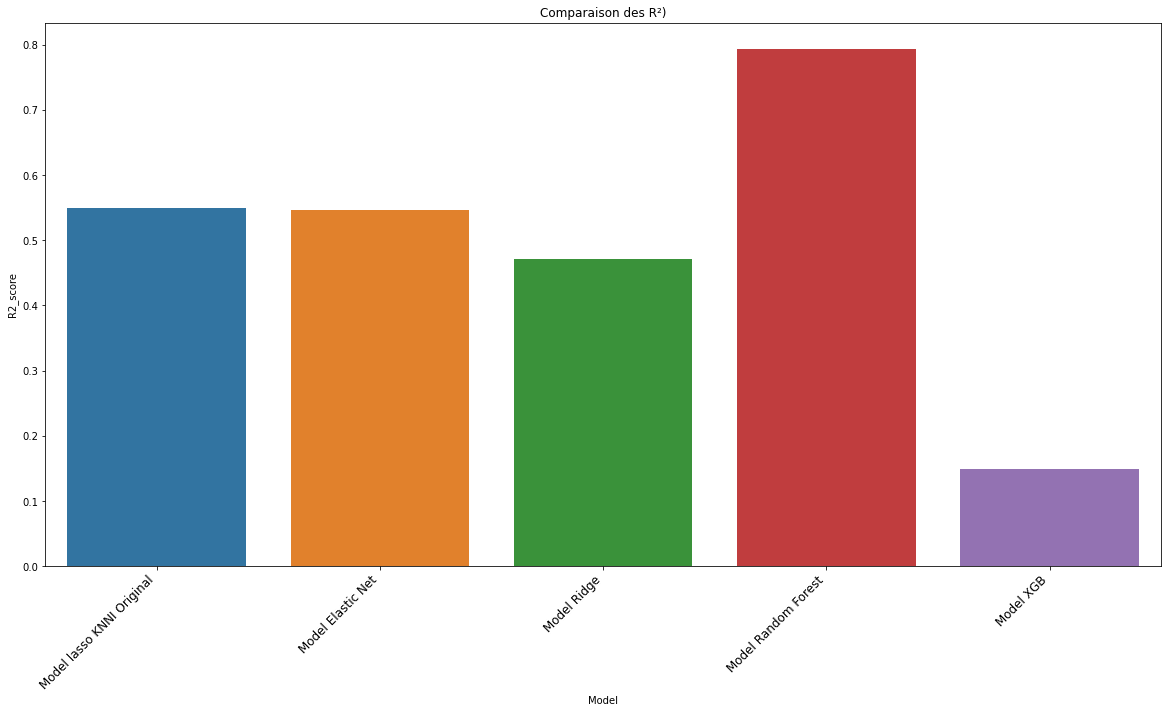

In [80]:
plt.figure(figsize=(20,10))
plt.title('Comparaison des R²)')
chart = sns.barplot(x = Data_Score['Model'],
           y = Data_Score['R2_score'])
chart.set_xticklabels(labels = Data_Score['Model'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
plt.show()

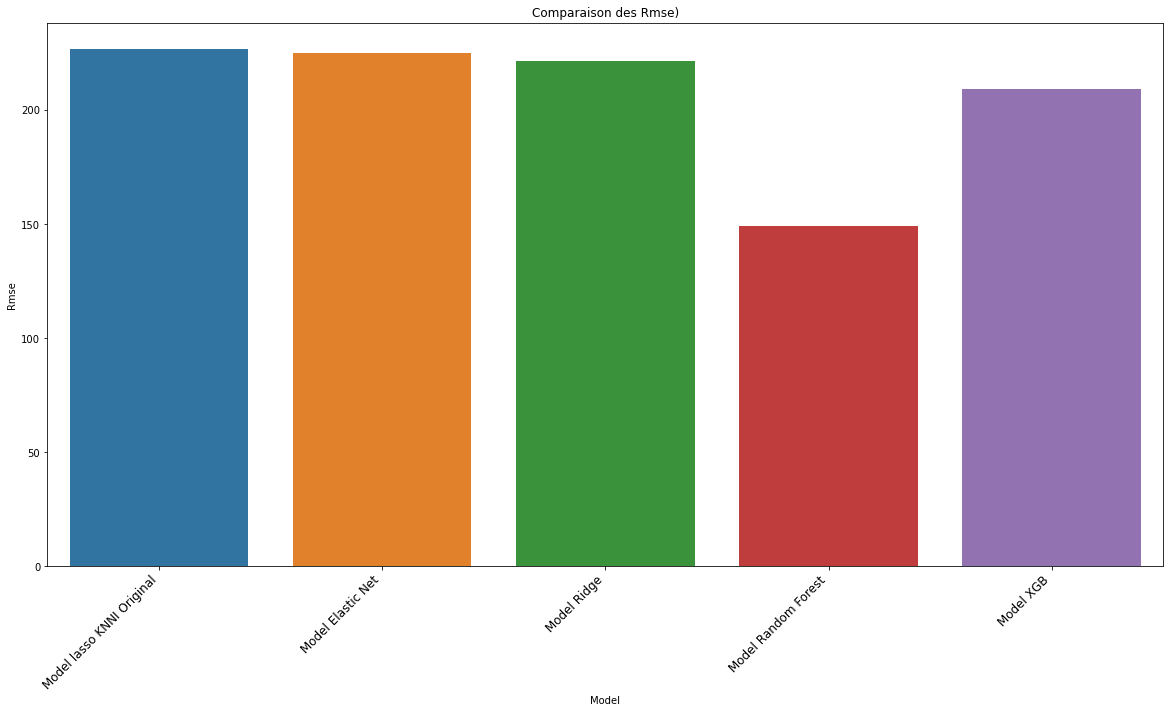

In [81]:
plt.figure(figsize=(20,10))
plt.title('Comparaison des Rmse)')
chart = sns.barplot(x = Data_Score['Model'],
           y = Data_Score['Rmse'])
chart.set_xticklabels(labels = Data_Score['Model'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
plt.show()

On obtient les meilleurs scores avec le modèles RandomForest Regressor. C'est le modèle que l'on selectionnera. 
On obtient des score R² négatifs avec le modèles de gradient Boostin ce qui montre que nos résultats avec ce modèles sont difficiles à interprétés et due à un manque de données sur ce modèle. 

# Milestone 5 : Analyse de la « feature importance » globale et locale

On regarde l'importance des features sur nos prédictions.

## Ridge feature importance

In [82]:
from  sklearn.linear_model import Ridge

In [83]:
Ridge_dict ={}
Ridge_dict["Variable"] = []
Ridge_dict["Score"] = []

In [84]:
for var, score in zip(Features, Ridge_Trained_OHE .coef_[0]):
    Ridge_dict ["Variable"].append(var)
    Ridge_dict ["Score"].append(score)

In [85]:
Ridge_feature_importance = pd.DataFrame(Ridge_dict , columns = ["Score"], index =Ridge_dict ["Variable"]).sort_values(by="Score", ascending = False, axis=0)
Ridge_feature_importance.head(30)

,Score
NaturalGas(kBtu) %,9.292677e-01
PrimaryPropertyType,5.881917e-01
SteamUse(kBtu) %,4.943230e-01
LargestPropertyUseType,4.328381e-01
x0_downtown,1.380136e-01
more_one_building,7.674783e-02
ThirdLargestPropertyUseType,7.406359e-02
CouncilDistrictCode,6.267497e-02
SecondLargestPropertyUseType,4.732997e-02
NumberofFloors,3.159718e-02


Les variables Consommations d'électricité et surface totale du batiment influencent grandement les émissions de CO² du batiment. 

In [86]:
rfi  = Ridge_feature_importance.reset_index()

In [87]:
rfi  

,index,Score
0,NaturalGas(kBtu) %,9.292677e-01
1,PrimaryPropertyType,5.881917e-01
2,SteamUse(kBtu) %,4.943230e-01
3,LargestPropertyUseType,4.328381e-01
4,x0_downtown,1.380136e-01
5,more_one_building,7.674783e-02
6,ThirdLargestPropertyUseType,7.406359e-02
7,CouncilDistrictCode,6.267497e-02
8,SecondLargestPropertyUseType,4.732997e-02
9,NumberofFloors,3.159718e-02


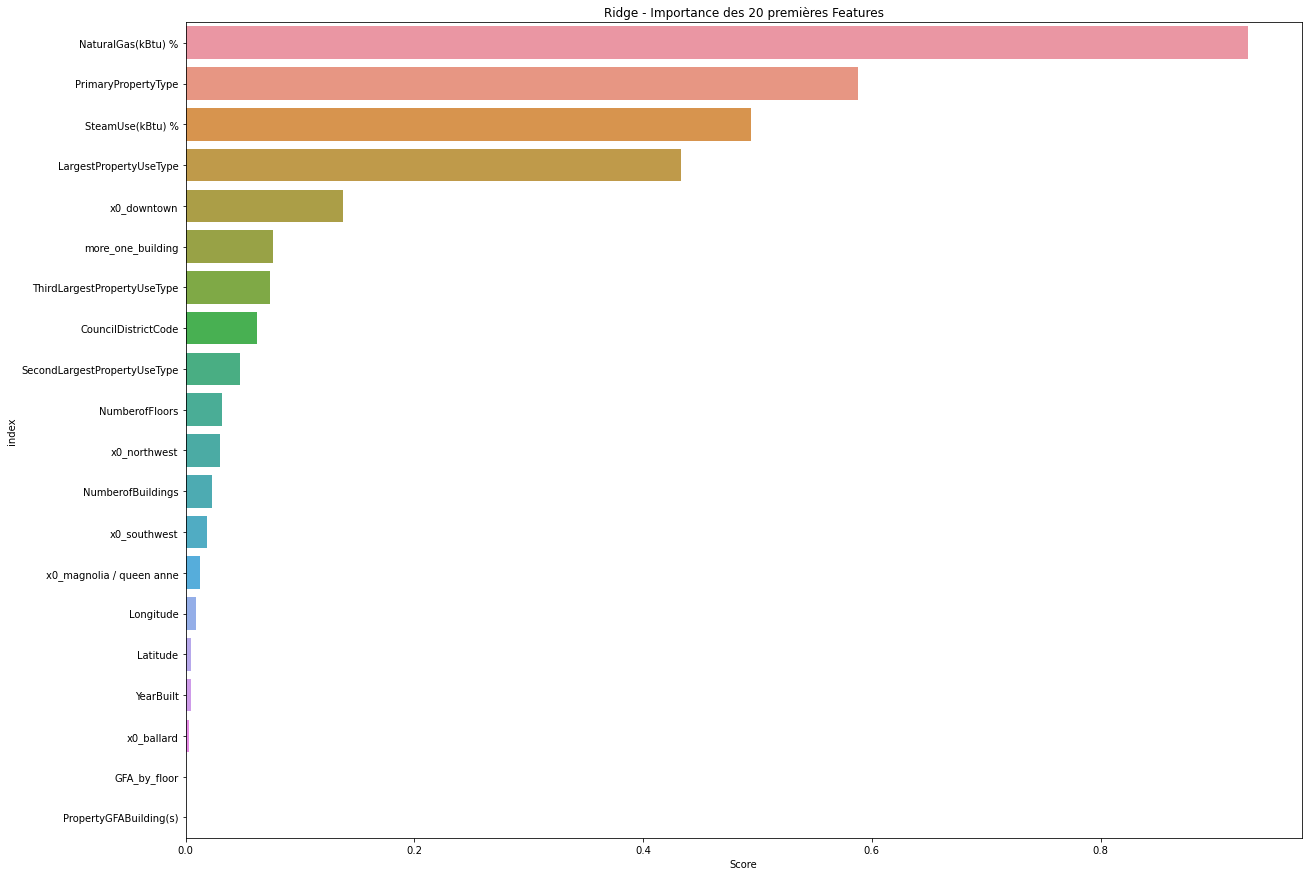

In [88]:
plt.figure(figsize=(20,15))
plt.title('Ridge - Importance des 20 premières Features')
sns.barplot(y = rfi ['index'].head(20),
            x = rfi ['Score'].head(20))
plt.show()

In [89]:
import shap

Importance des features.

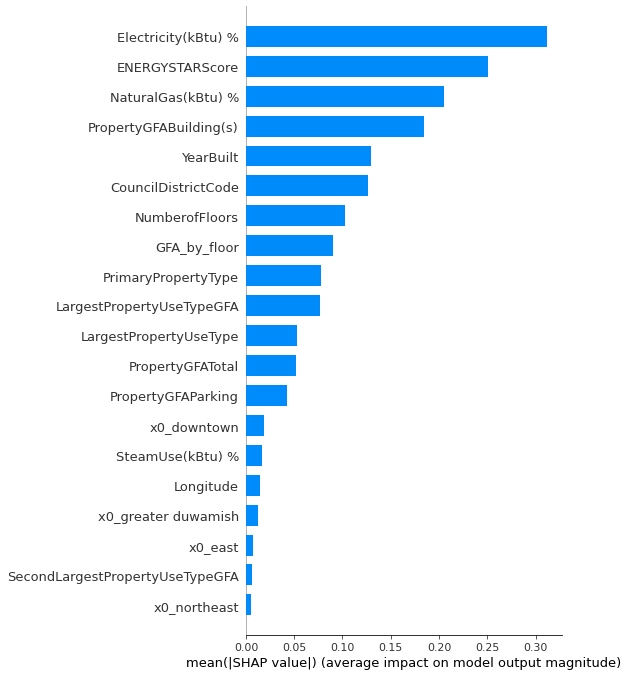

In [90]:
explainer = shap.explainers.Linear(Ridge_Trained_OHE, masker = Data_use[Features])
shap_values = explainer.shap_values(Data_use[Features])
shap.summary_plot(shap_values, Data_use[Features], plot_type='bar')

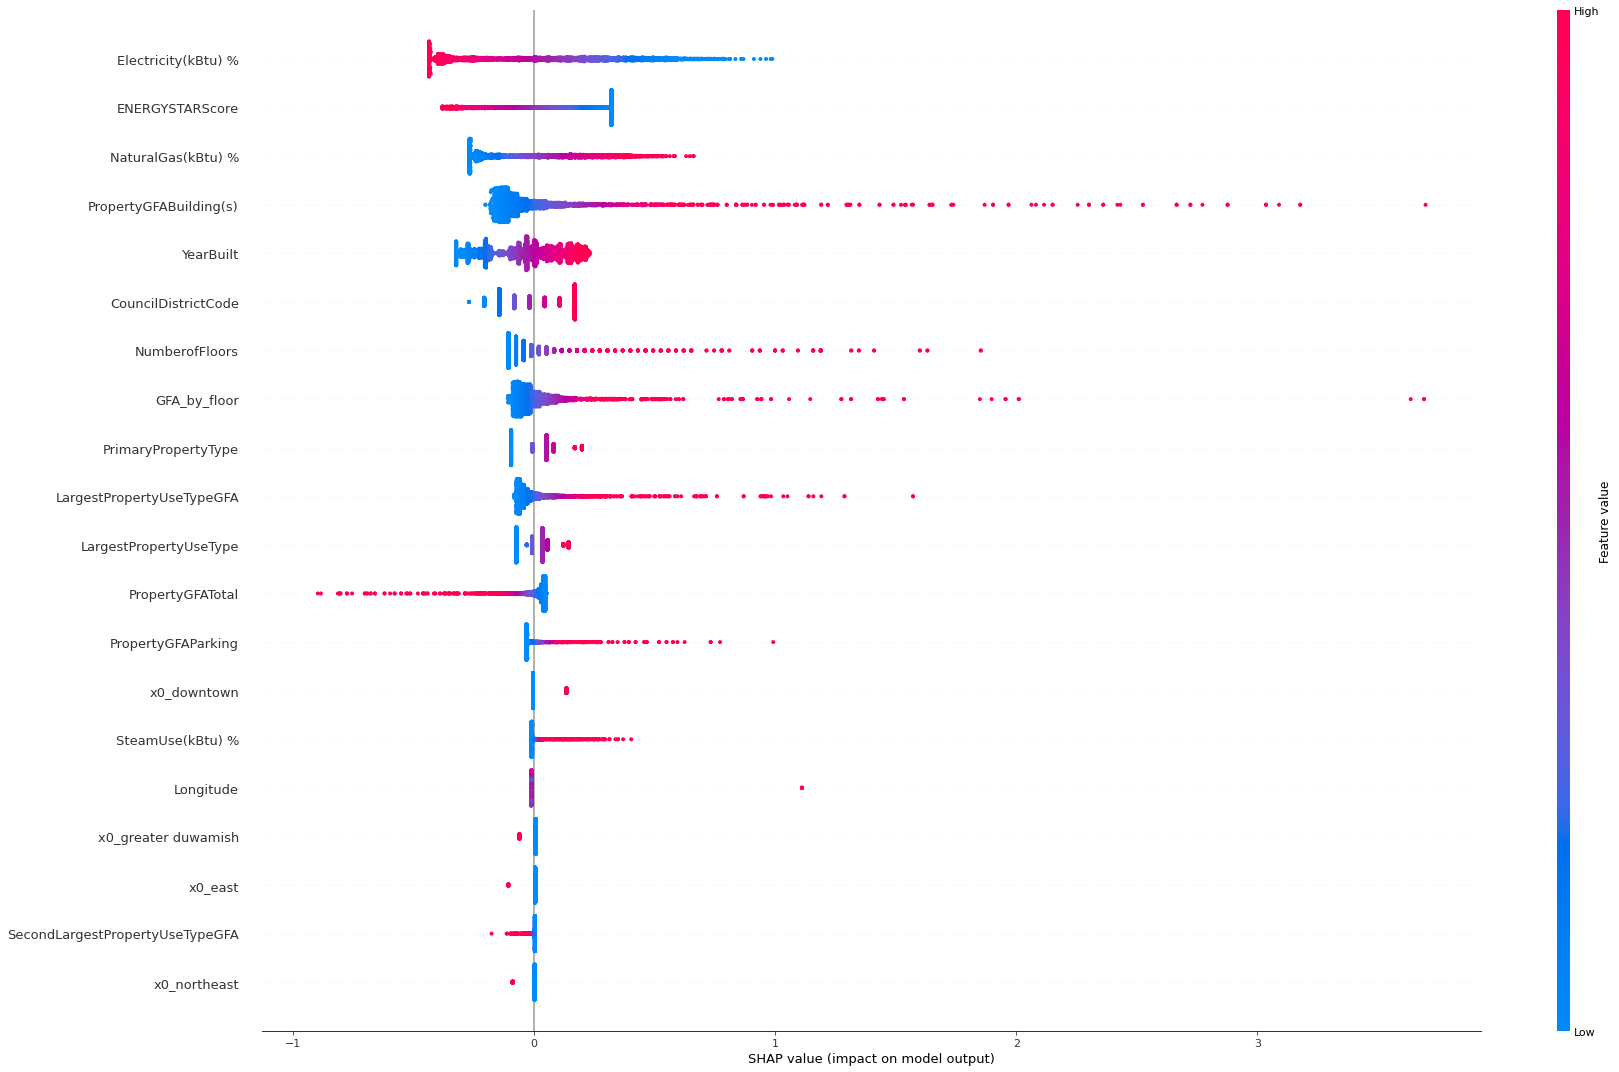

In [91]:
shap.summary_plot(shap_values, Data_use[Features],plot_size =(25,15))

On confirme graphiquement nos observations théoriques.

# Random Forest 

In [92]:
RF_dict = {}
RF_dict["Variable"] = []
RF_dict["Score"] = []


In [93]:
for var, score in zip(Features, RandomF_Trained_OHE.feature_importances_):
    RF_dict["Variable"].append(var)
    RF_dict["Score"].append(score)

rf_feature_importance = pd.DataFrame(RF_dict, columns = ["Score"], index=RF_dict ["Variable"]).sort_values(by="Score", ascending = False, axis=0)
rf_feature_importance.head(30)

,Score
PropertyGFABuilding(s),0.118636
Electricity(kBtu) %,0.095049
ENERGYSTARScore,0.079153
Latitude,0.072996
NaturalGas(kBtu) %,0.064123
GFA_by_floor,0.063851
LargestPropertyUseTypeGFA,0.060141
PropertyGFATotal,0.055025
YearBuilt,0.054397
Longitude,0.054120


In [94]:
RForest = rf_feature_importance.reset_index()

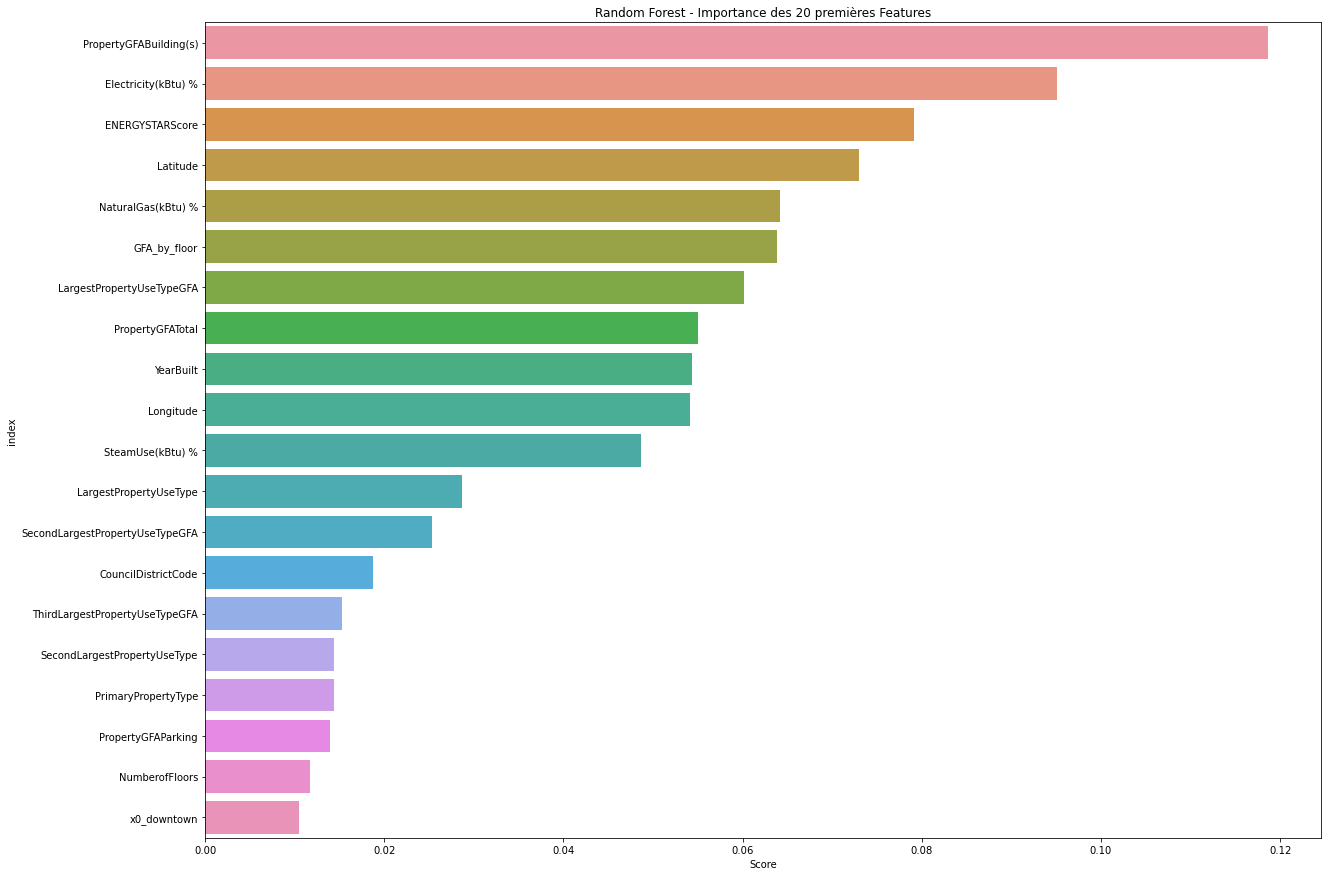

In [95]:
plt.figure(figsize=(20,15))
plt.title('Random Forest - Importance des 20 premières Features')
sns.barplot(y = RForest['index'].head(20),
            x = RForest['Score'].head(20))
plt.show()

Avec le random forest Regressor on a des résultats similaires. La surface des résidences secondaires impactera plus dans ce cas là.

In [96]:
RForest

,index,Score
0,PropertyGFABuilding(s),0.118636
1,Electricity(kBtu) %,0.095049
2,ENERGYSTARScore,0.079153
3,Latitude,0.072996
4,NaturalGas(kBtu) %,0.064123
5,GFA_by_floor,0.063851
6,LargestPropertyUseTypeGFA,0.060141
7,PropertyGFATotal,0.055025
8,YearBuilt,0.054397
9,Longitude,0.054120


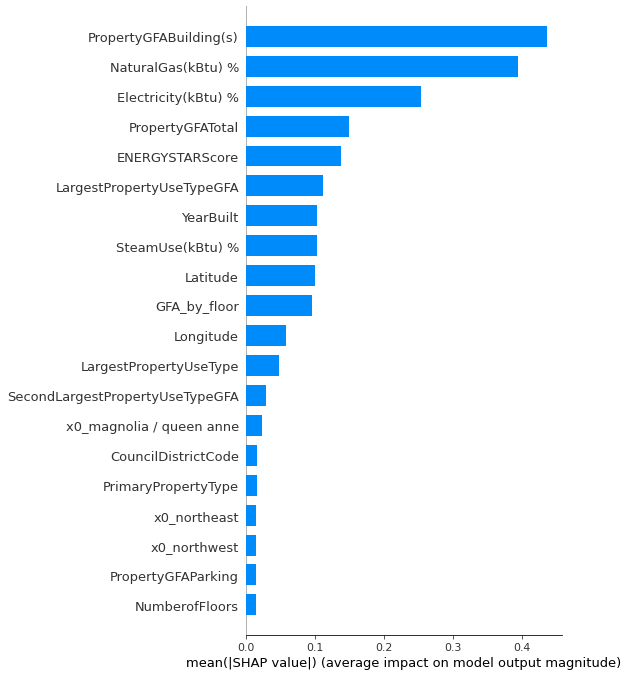

In [97]:
explainer = shap.TreeExplainer(RandomF_Trained_OHE )
shap_values = explainer.shap_values(Data_use[Features],approximate=True, check_additivity=False)
shap.summary_plot(shap_values, Data_use[Features], plot_type='bar')

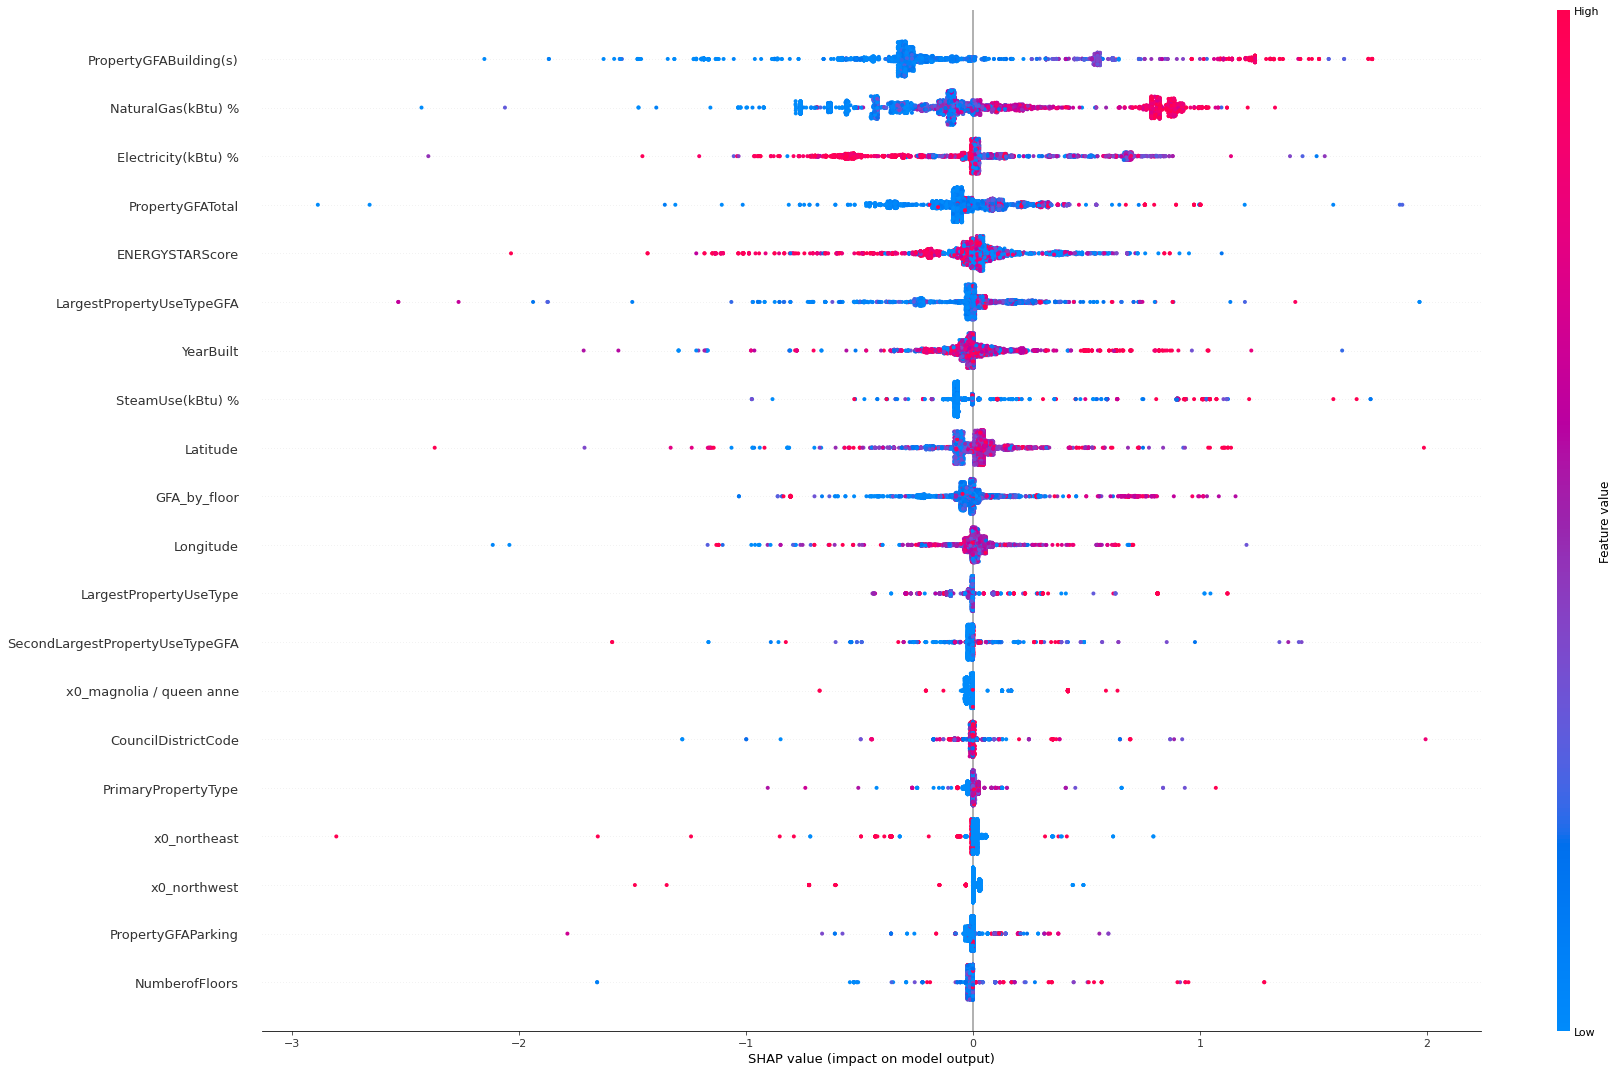

In [98]:
shap.summary_plot(shap_values,  Data_use[Features],plot_size =(25,15))

## OLS

In [99]:
model = sm.OLS(y_train,x_train)
results = model.fit()
print('Impacts des variables',results.summary())

Impacts des variables                               OLS Regression Results                             
Dep. Variable:     Log TotalGHGEmissions   R-squared:                       0.622
Model:                               OLS   Adj. R-squared:                  0.616
Method:                    Least Squares   F-statistic:                     111.5
Date:                   Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                           14:39:30   Log-Likelihood:                -3248.0
No. Observations:                   2480   AIC:                             6570.
Df Residuals:                       2443   BIC:                             6785.
Df Model:                             36                                         
Covariance Type:               nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

L'O.L.S permet de décrire la relation entre les variables d'entrée et la cible. Les features "Use Type" ainsi que les  ont le plus d'impactent sur le résultat significatif.

## Prédiction et Valeurs réelles

In [100]:
x_train, x_test, y_train, y_test = OHE_Train_Test_Split (Data_use, target, Features)

In [101]:
Model_RF_Reg = RandomForestRegressor(max_depth = 10, max_leaf_nodes =  100, n_estimators =  100, random_state = 0)
Model_RF_Reg .fit(x_train ,y_train)
y_Predict = Model_RF_Reg.predict(Data_use[Features])

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


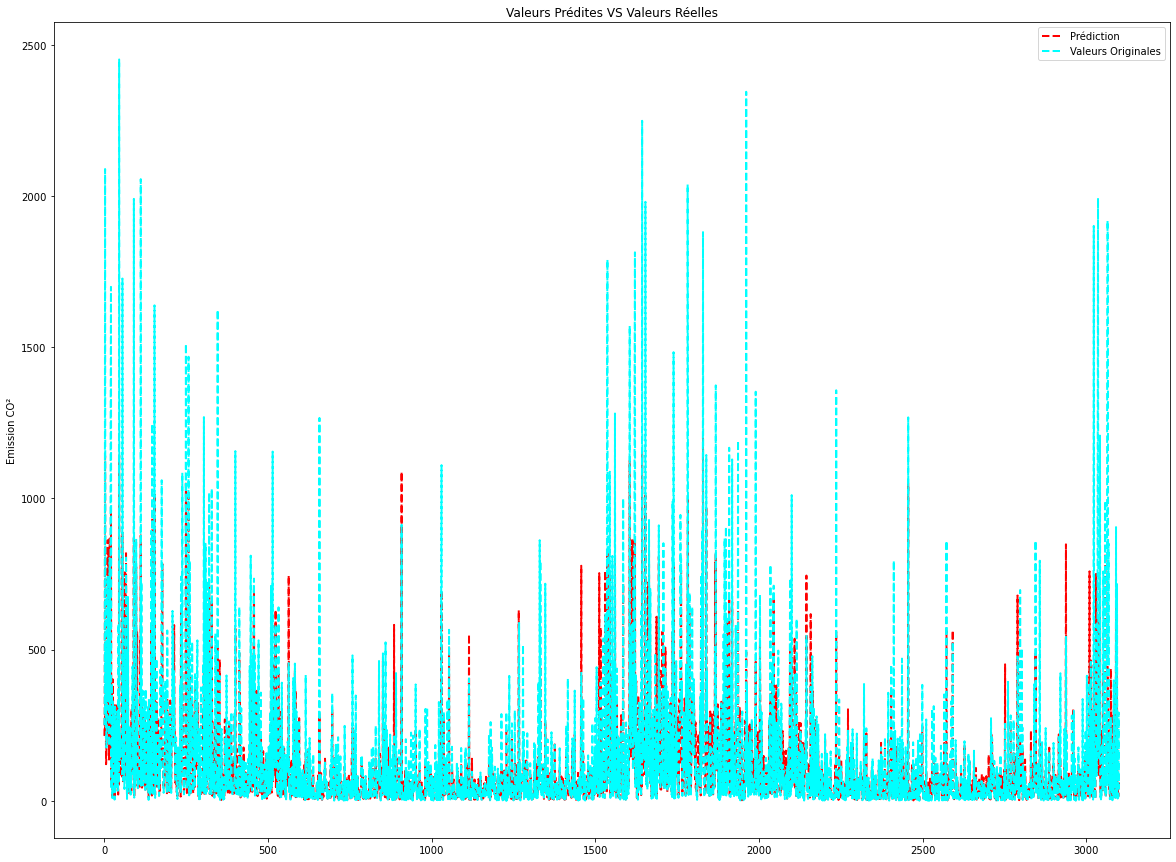

In [102]:
plt.figure(figsize=(20,15))
plt.plot(np.exp(y_Predict), color='red', linestyle='dashed',linewidth=2, markersize=12, label ='Prédiction')
plt.plot(np.exp(Data_use[target]), color='cyan', linestyle='dashed',linewidth=2, markersize=12, label ='Valeurs Originales')
plt.ylabel ("Emission CO²")
plt.title("Valeurs Prédites VS Valeurs Réelles")
plt.legend()

On a des valeurs prédites et réelles très proches. Ce sont les pics de valeurs qui ont en générale du mal a être prédites.

# Milestone 6 : Analyse de l’influence de l’EnergyStarScore

On teste les modèles sans la feature Energy Star Score

## Lasso 

In [103]:
Features_without_nrj_stars = Features.copy()
Features_without_nrj_stars.remove('ENERGYSTARScore')

In [104]:
lasso_grid = model_ml_HP(Lasso(), parameters_lasso,"r2" ,Data_use, target, Features_without_nrj_stars)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.249 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 839.2979004841799, tolerance: 415.04149126757324
Objective did not converge. You might want to increase the number of iterations. Duality gap: 851.1900108701756, tolerance: 425.46366025175297


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.439 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 881.7391666374245, tolerance: 421.3455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 853.177024062215, tolerance: 411.4773002629998


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.467 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=-36.855 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.3547764063529, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 839.2979004841799, tolerance: 41.50414912675732


[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.249 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.482 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 851.1900108701756, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 881.7391666374245, tolerance: 42.13455231990337


[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.439 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.467 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 853.177024062215, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.3547764063529, tolerance: 41.514135663866156


[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=-36.855 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.249 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 839.2979004841799, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 851.1900108701756, tolerance: 4.25463660251753


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.439 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 881.7391666374245, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 853.177024062215, tolerance: 4.114773002629998


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.467 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=-36.855 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.3547764063529, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 839.2979004841799, tolerance: 0.4150414912675732


[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.249 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.482 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 851.1900108701756, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 881.7391666374245, tolerance: 0.42134552319903373


[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.439 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.467 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 853.177024062215, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.3547764063529, tolerance: 0.4151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 840.7634222217821, tolerance: 415.04149126757324


[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=-36.855 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.249 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 856.7700319793556, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 883.7085476138592, tolerance: 421.3455231990337


[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.440 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.4693345714743, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.4339609805542, tolerance: 415.1413566386616


[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.467 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=-36.881 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 840.7634222217821, tolerance: 41.50414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 856.7700319793556, tolerance: 42.546366025175296


[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.249 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.482 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 883.7085476138592, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.4693345714743, tolerance: 41.14773002629998


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.440 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.467 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.4339609805542, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 840.7634222217821, tolerance: 4.150414912675732


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=-36.881 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.249 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 856.7700319793556, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 883.7085476138592, tolerance: 4.213455231990337


[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.440 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.4693345714743, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.4339609805542, tolerance: 4.151413566386616


[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.467 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=-36.881 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 840.7634222217821, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 856.7700319793556, tolerance: 0.425463660251753


[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.249 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.482 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 883.7085476138592, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.4693345714743, tolerance: 0.4114773002629998


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.440 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.467 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.4339609805542, tolerance: 0.4151413566386616


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=-36.881 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.265 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 629.1888193930475, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 862.3408385808146, tolerance: 421.3455231990337


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.485 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.449 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 834.0437771659874, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 855.6163957954399, tolerance: 415.1413566386616


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.473 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.493 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.265 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.485 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 629.1888193930475, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 862.3408385808146, tolerance: 42.13455231990337


[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.449 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.473 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 834.0437771659874, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 855.6163957954399, tolerance: 41.514135663866156


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.493 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.265 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.440400018872424, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 629.1888193930475, tolerance: 4.25463660251753


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.485 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.449 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 862.3408385808146, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 834.0437771659874, tolerance: 4.114773002629998


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.473 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.493 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 855.6163957954399, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.440400018872424, tolerance: 0.4150414912675732


[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.265 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.485 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 629.1888193930475, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 862.3408385808146, tolerance: 0.42134552319903373


[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.449 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.473 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 834.0437771659874, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 855.6163957954399, tolerance: 0.4151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 858.0355556908573, tolerance: 415.04149126757324


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.493 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.265 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 875.0673723231783, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 903.0810033129677, tolerance: 421.3455231990337


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.485 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.450 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 875.4877112598837, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 856.4029401352436, tolerance: 415.1413566386616


[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.473 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.493 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 858.0355556908573, tolerance: 41.50414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 875.0673723231783, tolerance: 42.546366025175296


[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.265 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.485 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 903.0810033129677, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 875.4877112598837, tolerance: 41.14773002629998


[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.450 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.473 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 856.4029401352436, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 858.0355556908573, tolerance: 4.150414912675732


[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.493 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.265 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 875.0673723231783, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 903.0810033129677, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 875.4877112598837, tolerance: 4.114773002629998


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.485 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.450 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.473 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.493 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 856.4029401352436, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 858.0355556908573, tolerance: 0.4150414912675732


[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.265 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.485 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 875.0673723231783, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 903.0810033129677, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 875.4877112598837, tolerance: 0.4114773002629998


[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.450 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.473 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 856.4029401352436, tolerance: 0.4151413566386616


[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.493 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.284 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.461 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.450 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.3623850702375, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 974.5501722451991, tolerance: 415.1413566386616


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.500 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.284 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.483 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 138.81954954576895, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.21386315325299, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.3623850702375, tolerance: 41.14773002629998


[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.461 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.450 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 974.5501722451991, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 138.81954954576895, tolerance: 4.25463660251753


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.500 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.284 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.483 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.21386315325299, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.3623850702375, tolerance: 4.114773002629998


[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.461 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.450 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 974.5501722451991, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0698672258699844, tolerance: 0.4150414912675732


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.284 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 138.81954954576895, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.21386315325299, tolerance: 0.42134552319903373


[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.483 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.461 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.3623850702375, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 974.5501722451991, tolerance: 0.4151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 945.2409305790649, tolerance: 415.04149126757324


[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.450 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.284 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.461 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 994.8667532788155, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1021.1952283793971, tolerance: 421.3455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 990.3962767599556, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 984.234077469137, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 945.2409305790649, tolerance: 41.50414912675732


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.450 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.500 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.284 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 994.8667532788155, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1021.1952283793971, tolerance: 42.13455231990337


[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.483 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.461 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 990.3962767599556, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 984.234077469137, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 945.2409305790649, tolerance: 4.150414912675732


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.450 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.500 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.284 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.483 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.461 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 994.8667532788155, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1021.1952283793971, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 990.3962767599556, tolerance: 4.114773002629998


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.450 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.500 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 984.234077469137, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 945.2409305790649, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 994.8667532788155, tolerance: 0.425463660251753


[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.284 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.483 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.461 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1021.1952283793971, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 990.3962767599556, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 984.234077469137, tolerance: 0.4151413566386616


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.450 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.226 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.357 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.326 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.324 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1251.9908199813594, tolerance: 415.1413566386616


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.346 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.226 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.357 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.326 total time=   0.1s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.324 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 149.4174672619331, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1251.9908199813594, tolerance: 41.514135663866156


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.346 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.226 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.357 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.412367410476236, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.387524235456567, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 149.4174672619331, tolerance: 4.114773002629998


[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.326 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.324 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.346 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1251.9908199813594, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.412367410476236, tolerance: 0.425463660251753


[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.226 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.357 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.326 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.387524235456567, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 149.4174672619331, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1251.9908199813594, tolerance: 0.4151413566386616


[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.324 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.346 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 890.2831541567025, tolerance: 415.04149126757324
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1280.7088717768415, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1271.9325741971031, tolerance: 421.3455231990337


[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.226 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.357 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.326 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1377.741181090806, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1413.7438271391675, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 890.2831541567025, tolerance: 41.50414912675732


[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.324 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.346 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.226 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.357 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.326 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1280.7088717768415, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1271.9325741971031, tolerance: 42.13455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1377.741181090806, tolerance: 41.14773002629998


[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.324 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.346 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.226 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1413.7438271391675, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 890.2831541567025, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1280.7088717768415, tolerance: 4.25463660251753


[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.357 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.326 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1271.9325741971031, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1377.741181090806, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1413.7438271391675, tolerance: 4.151413566386616


[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.324 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.346 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.226 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 890.2831541567025, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1280.7088717768415, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1271.9325741971031, tolerance: 0.42134552319903373


[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.357 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.326 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.324 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1377.741181090806, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1413.7438271391675, tolerance: 0.4151413566386616


[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.346 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=-0.029 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.082 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.082 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=-0.029 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.082 total time=   0.0s
[CV 5/5] END alph

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1723316421434902, tolerance: 0.4114773002629998


[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.082 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.082 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=-0.029 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.082 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.082 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=-0.029 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 606.9351712018617, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 690.6581710761659, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.18232989548733, tolerance: 4.150414912675732


[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.082 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.082 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=-0.029 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.082 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 606.9351712018617, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 690.6581710761659, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.18232989548733, tolerance: 0.4150414912675732


[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.082 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=-0.029 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 606.9351712018617, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 690.6581710761659, tolerance: 0.4151413566386616


[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.082 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.082 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=-0.022 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.080 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=-0.022 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=-0.030 total time=   0.0s
[CV 4/5] 

Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.392065786962576, tolerance: 0.4114773002629998


[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=-0.031 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.081 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.079 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=-0.031 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.081 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.079 total time=   0.0s
[

In [105]:
print(f"Les Hyperparamètres optimisés de notre modèles sont : {lasso_grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèles sont : [{'alpha': 0.01, 'random_state': 0, 'selection': 'cyclic', 'tol': 0.1}]


In [106]:
model_lasso = Lasso(alpha = 0.01, random_state =  0, tol =  0.1, selection = 'cyclic')

In [107]:
lasso_resume, Lasso_Trained = Modele_ML(model_lasso ,Data_use, 
                                        target, Features_without_nrj_stars, 'Model lasso W Energy')

mse = 58771.633944383924
rmse = 242.4286161829579
mae = 72.70122995735566
explained_var = 0.5601249660286443
r2_score = 0.5188091976282189
cross_validation_score [0.19840301 0.50512452 0.55935848 0.52658732 0.51820732] 


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1160.9826947838264, tolerance: 561.060932011404


In [108]:
Data_add = pd.DataFrame(data = lasso_resume)
Data_Score = Data_Score.append(Data_add )
Data_Score

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,51471.53,226.87,69.84,0.60,0.5495,0.113424,"[0.22827110673814854, 0.5425021510328911, 0.59...","[4.660637070463949, 2.9152320751730034, 3.0335..."
0,Model Elastic Net,50645.99,225.05,69.30,0.59,0.5464,0.163495,"[0.2372771928325057, 0.5226219859995997, 0.591...","[4.609596534515802, 2.82917495358004, 2.942645..."
0,Model Ridge,49084.62,221.55,70.95,0.52,0.4713,0.007972,"[0.22458236824792943, 0.463539884823041, 0.539...","[[4.546289110672857], [2.9513714473568093], [3..."
0,Model Random Forest,22270.71,149.23,48.16,0.80,0.7940,4.302208,"[0.6153886504060896, 0.699311254505876, 0.7628...","[4.3849641987633765, 1.8074747277980405, 2.852..."
0,Model XGB,43833.67,209.36,87.87,0.53,0.1495,1.459907,"[0.5014861567583295, 0.12860564998365376, 0.41...","[5.3307740446206475, 2.4321687194199986, 3.926..."
0,Model lasso W Energy,58771.63,242.43,72.70,0.56,0.5188,0.109705,"[0.19840300593723992, 0.5051245188155515, 0.55...","[4.457091336270679, 3.0119683256964294, 3.2131..."


## ElasticNet

In [109]:
ElasticNet_Grid = model_ml_HP(ElasticNet(), parameters_EN,"r2" ,Data_use, target, Features_without_nrj_stars)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.248 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 839.8596760922842, tolerance: 415.04149126757324
Objective did not converge. You might want to increase the number of iterations. Duality gap: 854.1595305097154, tolerance: 425.46366025175297


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.482 total time=   0.1s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.438 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 882.2350042508804, tolerance: 421.3455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 853.4421086564214, tolerance: 411.4773002629998


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=-40.191 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 834.9968644874991, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 839.8596760922842, tolerance: 41.50414912675732


[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.482 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 854.1595305097154, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 882.2350042508804, tolerance: 42.13455231990337


[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.438 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.466 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 853.4421086564214, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 834.9968644874991, tolerance: 41.514135663866156


[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=-40.191 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.248 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 839.8596760922842, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 854.1595305097154, tolerance: 4.25463660251753


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.438 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 882.2350042508804, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 853.4421086564214, tolerance: 4.114773002629998


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.466 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 834.9968644874991, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 839.8596760922842, tolerance: 0.4150414912675732


[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=-40.191 total time=   0.2s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.248 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 854.1595305097154, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 882.2350042508804, tolerance: 0.42134552319903373


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.438 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 853.4421086564214, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 834.9968644874991, tolerance: 0.4151413566386616


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.466 total time=   0.1s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=-40.191 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 840.5659785149932, tolerance: 415.04149126757324
Objective did not converge. You might want to increase the number of iterations. Duality gap: 856.6534190045957, tolerance: 425.46366025175297


[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.482 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 883.5086535819461, tolerance: 421.3455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.2787636159496, tolerance: 411.4773002629998


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.440 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.466 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.0373010676165, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 840.5659785149932, tolerance: 41.50414912675732


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=-40.216 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.248 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 856.6534190045957, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 883.5086535819461, tolerance: 42.13455231990337


[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.440 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.2787636159496, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.0373010676165, tolerance: 41.514135663866156


[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=-40.216 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 840.5659785149932, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 856.6534190045957, tolerance: 4.25463660251753


[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.482 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 883.5086535819461, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.2787636159496, tolerance: 4.114773002629998


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.440 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.466 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.0373010676165, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 840.5659785149932, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 856.6534190045957, tolerance: 0.425463660251753


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=-40.216 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.248 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.440 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 883.5086535819461, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.2787636159496, tolerance: 0.4114773002629998


[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=-40.216 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.0373010676165, tolerance: 0.4151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 811.373754056287, tolerance: 415.04149126757324
Objective did not converge. You might want to increase the number of iterations. Duality gap: 734.6559575121522, tolerance: 425.46366025175297


[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.258 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.485 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 890.227570442352, tolerance: 421.3455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 852.8977105837529, tolerance: 411.4773002629998


[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.445 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.469 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 853.7840673517309, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 811.373754056287, tolerance: 41.50414912675732


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.418 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.258 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 734.6559575121522, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 890.227570442352, tolerance: 42.13455231990337


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.485 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.445 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 852.8977105837529, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 853.7840673517309, tolerance: 41.514135663866156


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.469 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.418 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 811.373754056287, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 734.6559575121522, tolerance: 4.25463660251753


[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.258 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.485 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 890.227570442352, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 852.8977105837529, tolerance: 4.114773002629998


[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.445 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.469 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 853.7840673517309, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 811.373754056287, tolerance: 0.4150414912675732


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.418 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.258 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 734.6559575121522, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 890.227570442352, tolerance: 0.42134552319903373


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.485 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.445 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 852.8977105837529, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 853.7840673517309, tolerance: 0.4151413566386616


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.469 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.418 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.9939845734151, tolerance: 415.04149126757324
Objective did not converge. You might want to increase the number of iterations. Duality gap: 874.3886190311116, tolerance: 425.46366025175297


[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.258 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.485 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 902.0328269563613, tolerance: 421.3455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 874.3488195644717, tolerance: 411.4773002629998


[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.446 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.469 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 854.1821773728508, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.9939845734151, tolerance: 41.50414912675732


[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.417 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.258 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 874.3886190311116, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 902.0328269563613, tolerance: 42.13455231990337


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.485 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.446 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 874.3488195644717, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 854.1821773728508, tolerance: 41.514135663866156


[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.469 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.417 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.9939845734151, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 874.3886190311116, tolerance: 4.25463660251753


[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.258 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.485 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 902.0328269563613, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 874.3488195644717, tolerance: 4.114773002629998


[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.446 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.469 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 854.1821773728508, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.9939845734151, tolerance: 0.4150414912675732


[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.417 total time=   0.1s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.258 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 874.3886190311116, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 902.0328269563613, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 874.3488195644717, tolerance: 0.4114773002629998


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.485 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.446 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.469 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.417 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.288 total time=   0.0s

Objective did not converge. You might want to increase the number of iterations. Duality gap: 854.1821773728508, tolerance: 0.4151413566386616



[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.461 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.450 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.2286720258928, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 974.9120965305941, tolerance: 415.1413566386616


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.492 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.288 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 271.48108228961837, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 244.08725069762568, tolerance: 42.13455231990337


[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.461 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.2286720258928, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 974.9120965305941, tolerance: 41.514135663866156


[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.450 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.492 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.288 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 271.48108228961837, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 244.08725069762568, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.2286720258928, tolerance: 4.114773002629998


[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.461 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.450 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.492 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 974.9120965305941, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5831160033455944, tolerance: 0.4150414912675732


[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.288 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.482 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 271.48108228961837, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 244.08725069762568, tolerance: 0.42134552319903373


[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.461 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.450 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.2286720258928, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 974.9120965305941, tolerance: 0.4151413566386616


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.492 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.288 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 966.4426077685192, tolerance: 415.04149126757324
Objective did not converge. You might want to increase the number of iterations. Duality gap: 996.6625013745107, tolerance: 425.46366025175297


[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.461 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1025.144257874307, tolerance: 421.3455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 990.291287193939, tolerance: 411.4773002629998


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.450 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.492 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 979.7935735371561, tolerance: 415.1413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 966.4426077685192, tolerance: 41.50414912675732


[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.288 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.482 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 996.6625013745107, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1025.144257874307, tolerance: 42.13455231990337


[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.461 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.450 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 990.291287193939, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 979.7935735371561, tolerance: 41.514135663866156


[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.492 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.288 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 966.4426077685192, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 996.6625013745107, tolerance: 4.25463660251753


[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.461 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1025.144257874307, tolerance: 4.213455231990337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 990.291287193939, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 979.7935735371561, tolerance: 4.151413566386616


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.450 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.492 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 966.4426077685192, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 996.6625013745107, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1025.144257874307, tolerance: 0.42134552319903373


[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.288 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.461 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.450 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 990.291287193939, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 979.7935735371561, tolerance: 0.4151413566386616


[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.492 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.203 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.341 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.324 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.304 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1267.4259287048933, tolerance: 415.1413566386616


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.336 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.203 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.341 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.324 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.304 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 252.2446144963044, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1267.4259287048933, tolerance: 41.514135663866156


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.336 total time=   0.1s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.203 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.003971333762365, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.29676579096531, tolerance: 4.213455231990337


[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.341 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.324 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 252.2446144963044, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1267.4259287048933, tolerance: 4.151413566386616


[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.304 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.336 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.203 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.341 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.003971333762365, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.29676579096531, tolerance: 0.42134552319903373


[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.324 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.304 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 252.2446144963044, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1267.4259287048933, tolerance: 0.4151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1053.570563578103, tolerance: 415.04149126757324


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.336 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.203 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1300.1271799255508, tolerance: 425.46366025175297
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313.6132275391863, tolerance: 421.3455231990337


[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.341 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.324 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1347.5120772260104, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1356.1721720845148, tolerance: 415.1413566386616


[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.304 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.336 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1053.570563578103, tolerance: 41.50414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1300.1271799255508, tolerance: 42.546366025175296
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313.6132275391863, tolerance: 42.13455231990337


[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.203 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.341 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.324 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.304 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1347.5120772260104, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1356.1721720845148, tolerance: 41.514135663866156


[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.336 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.203 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1053.570563578103, tolerance: 4.150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1300.1271799255508, tolerance: 4.25463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313.6132275391863, tolerance: 4.213455231990337


[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.341 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.324 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1347.5120772260104, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1356.1721720845148, tolerance: 4.151413566386616


[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.304 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.336 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1053.570563578103, tolerance: 0.4150414912675732
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1300.1271799255508, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313.6132275391863, tolerance: 0.42134552319903373


[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.203 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.341 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.324 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.304 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1347.5120772260104, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1356.1721720845148, tolerance: 0.4151413566386616


[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.336 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=-0.020 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=-0.026 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.083 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.083 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=-0.020 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=-0.026 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.083 total time=   0.0s
[CV 5/5] END alph

Objective did not converge. You might want to increase the number of iterations. Duality gap: 199.9644009096678, tolerance: 41.514135663866156


[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=-0.020 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=-0.026 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.528981462563479, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 199.9644009096678, tolerance: 4.151413566386616


[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.083 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.083 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=-0.020 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=-0.026 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.083 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.528981462563479, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 199.9644009096678, tolerance: 0.4151413566386616


[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.083 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=-0.020 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=-0.026 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 975.5740676644767, tolerance: 411.4773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1268.0721323361508, tolerance: 415.1413566386616


[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.083 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.083 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 144.97115329930602, tolerance: 41.50414912675732


[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=-0.020 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=-0.026 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 975.5740676644767, tolerance: 41.14773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1268.0721323361508, tolerance: 41.514135663866156
Objective did not converge. You might want to increase the number of iterations. Duality gap: 144.97115329930602, tolerance: 4.150414912675732


[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.083 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.083 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=-0.020 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=-0.026 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 975.5740676644767, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1268.0721323361508, tolerance: 4.151413566386616
Objective did not converge. You might want to increase the number of iterations. Duality gap: 144.97115329930602, tolerance: 0.4150414912675732


[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.083 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.083 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=-0.020 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.945473316000516, tolerance: 0.425463660251753
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.281811061831377, tolerance: 0.42134552319903373
Objective did not converge. You might want to increase the number of iterations. Duality gap: 975.5740676644767, tolerance: 0.4114773002629998


[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=-0.026 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.083 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.083 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=-0.022 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.074 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1268.0721323361508, tolerance: 0.4151413566386616


[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.080 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=-0.022 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.080 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=-0.022 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.074 total time=   0.0s
[CV 3/5

Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.7079748587812, tolerance: 4.114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6948724028925426, tolerance: 0.4150414912675732


[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.080 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=-0.022 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.080 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=-0.021 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.7079748587812, tolerance: 0.4114773002629998
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7581188295644097, tolerance: 0.4151413566386616


[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.081 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.079 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.081 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.001;, score=-0.021 total time=   0.0s

Objective did not converge. You might want to increase the number of iterations. Duality gap: 619.3856198697952, tolerance: 526.7716099571713


In [110]:
print(f"Les Hyperparamètres optimisés de notre modèles sont : {ElasticNet_Grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèles sont : [{'alpha': 0.01, 'random_state': 0, 'selection': 'cyclic', 'tol': 0.1}]


In [111]:
Model_Elastic = ElasticNet(alpha = 0.01, random_state =  0, tol =  0.1, selection = "cyclic")

In [112]:
ElasticNet_resume, ElasticNet_Trained  = Modele_ML(Model_Elastic,Data_use, target, Features_without_nrj_stars, "Model Elastic Net W Energy")

Objective did not converge. You might want to increase the number of iterations. Duality gap: 619.3856198697952, tolerance: 526.7716099571713


mse = 55936.89836104227
rmse = 236.50982719760773
mae = 71.78366846075457
explained_var = 0.5557958915760886
r2_score = 0.5174217401691796
cross_validation_score [0.20735788 0.49087483 0.5614283  0.52351304 0.51683012] 


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1226.5965155459824, tolerance: 561.060932011404
Objective did not converge. You might want to increase the number of iterations. Duality gap: 619.6072675042104, tolerance: 526.8691851170121


In [113]:
Data_add = pd.DataFrame(data = ElasticNet_resume)
Data_Score = Data_Score.append(Data_add )
Data_Score

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,51471.53,226.87,69.84,0.60,0.5495,0.113424,"[0.22827110673814854, 0.5425021510328911, 0.59...","[4.660637070463949, 2.9152320751730034, 3.0335..."
0,Model Elastic Net,50645.99,225.05,69.30,0.59,0.5464,0.163495,"[0.2372771928325057, 0.5226219859995997, 0.591...","[4.609596534515802, 2.82917495358004, 2.942645..."
0,Model Ridge,49084.62,221.55,70.95,0.52,0.4713,0.007972,"[0.22458236824792943, 0.463539884823041, 0.539...","[[4.546289110672857], [2.9513714473568093], [3..."
0,Model Random Forest,22270.71,149.23,48.16,0.80,0.7940,4.302208,"[0.6153886504060896, 0.699311254505876, 0.7628...","[4.3849641987633765, 1.8074747277980405, 2.852..."
0,Model XGB,43833.67,209.36,87.87,0.53,0.1495,1.459907,"[0.5014861567583295, 0.12860564998365376, 0.41...","[5.3307740446206475, 2.4321687194199986, 3.926..."
0,Model lasso W Energy,58771.63,242.43,72.70,0.56,0.5188,0.109705,"[0.19840300593723992, 0.5051245188155515, 0.55...","[4.457091336270679, 3.0119683256964294, 3.2131..."
0,Model Elastic Net W Energy,55936.90,236.51,71.78,0.56,0.5174,0.128610,"[0.20735788358066287, 0.4908748330576431, 0.56...","[4.4203129450583845, 2.9694461432247703, 3.165..."


## Ridge 

In [114]:
Ridge_Grid = model_ml_HP(Ridge(), parameters_Ridge,"r2" ,Data_use, target, Features_without_nrj_stars)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.428 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=-60.176 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.482 total time=   0.0s


Ill-conditioned matrix (rcond=5.84984e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.97014e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87761e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13589e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84984e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.97014e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94585e-18): result may not be accurate.


[CV 3/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.428 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=-60.176 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=auto, tol=0.001;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=auto, tol=0.001;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=auto, tol=0.001;, score=0.428 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=auto, tol=0.001;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=auto, tol=0.001;, score=-60.176 total time=   0.0s


Ill-conditioned matrix (rcond=5.87761e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13589e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84984e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.97014e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87761e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13589e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84984e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.97014e-18): result may not be accurate.


[CV 1/5] END alpha=0.001, random_state=0, solver=auto, tol=0.0001;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=auto, tol=0.0001;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=auto, tol=0.0001;, score=0.428 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=auto, tol=0.0001;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=auto, tol=0.0001;, score=-60.176 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=svd, tol=0.1;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=svd, tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=svd, tol=0.1;, score=0.428 total time=   0.0s


Ill-conditioned matrix (rcond=3.94585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87761e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13589e-18): result may not be accurate.


[CV 4/5] END alpha=0.001, random_state=0, solver=svd, tol=0.1;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=svd, tol=0.1;, score=-60.176 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=0.428 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=-60.176 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=svd, tol=0.001;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=svd, tol=0.001;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=svd, tol=0.001;, score=0.428 total time=   0.0s
[CV 4/5] END alpha=0.001, random_st

Ill-conditioned matrix (rcond=5.84984e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.97014e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87761e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13589e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84984e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.97014e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87761e-18): result may not be accurate.


[CV 4/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.01;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.01;, score=-60.176 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.428 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=-60.176 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.482 total time=   0.0s


Ill-conditioned matrix (rcond=4.13589e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84984e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.97014e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87761e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13589e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84984e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.97014e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94585e-18): result may not be accurate.


[CV 3/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.428 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=-60.176 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.1;, score=-0.038 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.1;, score=0.079 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.1;, score=-0.048 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.1;, score=0.063 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.1;, score=0.077 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.01;, score=-0.023 total time=   0.0s


Ill-conditioned matrix (rcond=5.87761e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13589e-18): result may not be accurate.


[CV 2/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.01;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.01;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.01;, score=0.089 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.01;, score=0.081 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.001;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.001;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.001;, score=-0.031 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.001;, score=0.079 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.001;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.0001;, score=-0.022 total time=   0.0s
[CV 2/5] END alpha=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 2/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 4/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=auto, tol=0.1;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=auto, tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=auto, tol=0.1;, score=0.429 total time=   0.0s


Ill-conditioned matrix (rcond=5.87647e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13445e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.84838e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96918e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94485e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87647e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13445e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.84838e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96918e-17): result may not be accurate.


[CV 4/5] END alpha=0.01, random_state=0, solver=auto, tol=0.1;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=auto, tol=0.1;, score=-59.193 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=auto, tol=0.01;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=auto, tol=0.01;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=auto, tol=0.01;, score=0.429 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=auto, tol=0.01;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=auto, tol=0.01;, score=-59.193 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=auto, tol=0.001;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=auto, tol=0.001;, score=0.482 total time=   0.0s


Ill-conditioned matrix (rcond=3.94485e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87647e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13445e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.84838e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96918e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94485e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87647e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13445e-17): result may not be accurate.


[CV 3/5] END alpha=0.01, random_state=0, solver=auto, tol=0.001;, score=0.429 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=auto, tol=0.001;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=auto, tol=0.001;, score=-59.193 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=0.429 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=-59.193 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=svd, tol=0.1;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=svd, tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.01, ra

Ill-conditioned matrix (rcond=5.84838e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96918e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94485e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87647e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13445e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.84838e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96918e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94485e-17): result may not be accurate.


[CV 3/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.1;, score=0.429 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.1;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.1;, score=-59.193 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.01;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.01;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.01;, score=0.429 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.01;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.01;, score=-59.193 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.001;, score=0.245 total time=   0.0s


Ill-conditioned matrix (rcond=5.87647e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13445e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.84838e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96918e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94485e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87647e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13445e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.84838e-17): result may not be accurate.


[CV 2/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.001;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.001;, score=0.429 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.001;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.001;, score=-59.193 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.0001;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.0001;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.0001;, score=0.429 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.0001;, score=0.466 total time=   0.0s


Ill-conditioned matrix (rcond=3.96918e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94485e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87647e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13445e-17): result may not be accurate.


[CV 5/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.0001;, score=-59.193 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=-0.038 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=0.079 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=-0.048 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=0.063 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=0.077 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=-0.023 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=0.089 total time=   0.0s
[CV 5/5] END alpha=0.01, random_s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 4/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=l

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 4/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=auto, tol=0.1;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=auto, tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=auto, tol=0.1;, score=0.429 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=auto, tol=0.1;, score=0.466 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=auto, tol=0.1;, score=-50.618 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=auto, tol=0.01;, score=0.245 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=auto, tol=0.01;, score=0.482 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=auto, tol=0.01;, score=0.429 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=au

[CV 4/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.1;, score=0.063 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.1;, score=0.077 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.01;, score=-0.023 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.01;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.01;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.01;, score=0.089 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.01;, score=0.081 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.001;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.001;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.001;, score=-0.031 total time=   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 3/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=auto, tol=0.1;, score=0.252 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=auto, tol=0.1;, score=0.484 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=auto, tol=0.1;, score=0.445 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=auto, tol=0.1;, score=0.454 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=auto, tol=0.1;, score=-0.778 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=auto, tol=0.01;, score=0.252 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=auto, tol=0.01;, score=0.484 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=auto, tol=0.

[CV 4/5] END alpha=10, random_state=0, solver=sparse_cg, tol=0.01;, score=0.089 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=sparse_cg, tol=0.01;, score=0.081 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=sparse_cg, tol=0.001;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=sparse_cg, tol=0.001;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=sparse_cg, tol=0.001;, score=-0.031 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=sparse_cg, tol=0.001;, score=0.079 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=sparse_cg, tol=0.001;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=sparse_cg, tol=0.0001;, score=-0.022 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=sparse_cg, tol=0.0001;, score=-0.030 total time=   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 4/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 2/5] END alpha=100, random_state=0, solver=auto, tol=0.1;, score=0.417 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=auto, tol=0.1;, score=0.408 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=auto, tol=0.1;, score=0.370 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=auto, tol=0.1;, score=0.392 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.251 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.417 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.408 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.370 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.392 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=auto, tol=0.001;, score=0.251 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=auto, 

[CV 1/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.001;, score=-0.021 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.001;, score=0.073 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.001;, score=-0.031 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.001;, score=0.079 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.001;, score=0.080 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=-0.022 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.074 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=-0.030 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.080 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.080 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 1/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
 Fit time: 0.0137 MAE :-11.711 (std : +/- 48.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

In [115]:
print(f"Les Hyperparamètres optimisés de notre modèles sont : {Ridge_Grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèles sont : [{'alpha': 100, 'random_state': 0, 'solver': 'auto', 'tol': 0.1}]


In [116]:
Model_Ridge = Ridge(alpha =  100, random_state = 0, solver = "auto", tol =0.1)

In [117]:
Ridge_resume, Ridge_Trained  = Modele_ML( Model_Ridge, Data_use, target, Features_without_nrj_stars, "Model Ridge W Energy")

mse = 52196.25852914768
rmse = 228.46500504267098
mae = 72.36721155330024
explained_var = 0.4867743013091016
r2_score = 0.4472729534657962
cross_validation_score [0.20213303 0.44095938 0.51358137 0.46697579 0.4466639 ] 


In [118]:
Data_add = pd.DataFrame(data = Ridge_resume )
Data_Score = Data_Score.append(Data_add )
Data_Score

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,51471.53,226.87,69.84,0.60,0.5495,0.113424,"[0.22827110673814854, 0.5425021510328911, 0.59...","[4.660637070463949, 2.9152320751730034, 3.0335..."
0,Model Elastic Net,50645.99,225.05,69.30,0.59,0.5464,0.163495,"[0.2372771928325057, 0.5226219859995997, 0.591...","[4.609596534515802, 2.82917495358004, 2.942645..."
0,Model Ridge,49084.62,221.55,70.95,0.52,0.4713,0.007972,"[0.22458236824792943, 0.463539884823041, 0.539...","[[4.546289110672857], [2.9513714473568093], [3..."
0,Model Random Forest,22270.71,149.23,48.16,0.80,0.7940,4.302208,"[0.6153886504060896, 0.699311254505876, 0.7628...","[4.3849641987633765, 1.8074747277980405, 2.852..."
0,Model XGB,43833.67,209.36,87.87,0.53,0.1495,1.459907,"[0.5014861567583295, 0.12860564998365376, 0.41...","[5.3307740446206475, 2.4321687194199986, 3.926..."
0,Model lasso W Energy,58771.63,242.43,72.70,0.56,0.5188,0.109705,"[0.19840300593723992, 0.5051245188155515, 0.55...","[4.457091336270679, 3.0119683256964294, 3.2131..."
0,Model Elastic Net W Energy,55936.90,236.51,71.78,0.56,0.5174,0.128610,"[0.20735788358066287, 0.4908748330576431, 0.56...","[4.4203129450583845, 2.9694461432247703, 3.165..."
0,Model Ridge W Energy,52196.26,228.47,72.37,0.49,0.4473,0.013520,"[0.20213303394962534, 0.44095938260495104, 0.5...","[[4.316133909768759], [3.106887198042604], [3...."


## Random Forest 

In [119]:
RF_Grid = model_ml_HP(RandomForestRegressor(), parameters_RF,"r2" ,Data_use, target, Features_without_nrj_stars)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END max_depth=1, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=-0.611 total time=   0.0s
[CV 2/5] END max_depth=1, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.206 total time=   0.0s
[CV 3/5] END max_depth=1, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=-0.026 total time=   0.0s
[CV 4/5] END max_depth=1, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.172 total time=   0.0s
[CV 5/5] END max_depth=1, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.055 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=1, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=-0.582 total time=   0.0s
[CV 2/5] END max_depth=1, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.268 total time=   0.0s
[CV 3/5] END max_depth=1, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=-0.009 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=1, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.228 total time=   0.0s
[CV 5/5] END max_depth=1, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.306 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=1, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=-0.530 total time=   0.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=1, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.259 total time=   0.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=1, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=-0.038 total time=   0.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=1, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.185 total time=   0.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=1, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.273 total time=   0.8s
[CV 1/5] END max_depth=1, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=-0.611 total time=   0.0s
[CV 2/5] END max_depth=1, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.206 total time=   0.0s
[CV 3/5] END max_depth=1, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=-0.026 total time=   0.0s
[CV 4/5] END max_depth=1, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.172 total time=   0.0s
[CV 5/5] END max_depth=1, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.055 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=1, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=-0.582 total time=   0.0s
[CV 2/5] END max_depth=1, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.268 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=1, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=-0.009 total time=   0.0s
[CV 4/5] END max_depth=1, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.228 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=1, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.306 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=1, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=-0.530 total time=   0.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=1, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.259 total time=   0.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=1, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=-0.038 total time=   0.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=1, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.185 total time=   0.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=1, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.273 total time=   0.8s
[CV 1/5] END max_depth=5, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.463 total time=   0.0s
[CV 2/5] END max_depth=5, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.559 total time=   0.0s
[CV 3/5] END max_depth=5, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.460 total time=   0.0s
[CV 4/5] END max_depth=5, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.592 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=5, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.573 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=5, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.518 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=5, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.624 total time=   0.1s
[CV 3/5] END max_depth=5, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.551 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=5, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.640 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=5, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.652 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=5, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.527 total time=   2.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=5, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.630 total time=   2.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=5, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.555 total time=   2.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=5, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.643 total time=   2.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=5, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.666 total time=   1.9s
[CV 1/5] END max_depth=5, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.518 total time=   0.0s
[CV 2/5] END max_depth=5, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.568 total time=   0.0s
[CV 3/5] END max_depth=5, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.527 total time=   0.0s
[CV 4/5] END max_depth=5, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.634 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=5, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.544 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=5, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.604 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=5, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.651 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=5, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.573 total time=   0.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=5, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.695 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=5, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.701 total time=   0.1s
[CV 1/5] END max_depth=5, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.616 total time=   2.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=5, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.660 total time=   2.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=5, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.579 total time=   2.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=5, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.698 total time=   1.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=5, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.712 total time=   1.7s
[CV 1/5] END max_depth=10, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.463 total time=   0.0s
[CV 2/5] END max_depth=10, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.559 total time=   0.0s
[CV 3/5] END max_depth=10, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.460 total time=   0.0s
[CV 4/5] END max_depth=10, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.592 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=10, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.573 total time=   0.0s
[CV 1/5] END max_depth=10, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.518 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=10, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.624 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=10, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.551 total time=   0.1s
[CV 4/5] END max_depth=10, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.640 total time=   0.1s
[CV 5/5] END max_depth=10, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.652 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=10, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.527 total time=   1.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=10, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.630 total time=   1.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=10, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.555 total time=   1.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=10, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.643 total time=   2.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=10, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.666 total time=   2.0s
[CV 1/5] END max_depth=10, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.424 total time=   0.0s
[CV 2/5] END max_depth=10, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.548 total time=   0.0s
[CV 3/5] END max_depth=10, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.384 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=10, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.599 total time=   0.0s
[CV 5/5] END max_depth=10, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.558 total time=   0.0s
[CV 1/5] END max_depth=10, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.642 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=10, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.696 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=10, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.578 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=10, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.716 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=10, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.739 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=10, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.665 total time=   3.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=10, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.701 total time=   3.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=10, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.598 total time=   3.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=10, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.735 total time=   3.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=10, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.753 total time=   3.7s
[CV 1/5] END max_depth=20, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.463 total time=   0.0s
[CV 2/5] END max_depth=20, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.559 total time=   0.0s
[CV 3/5] END max_depth=20, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.460 total time=   0.0s
[CV 4/5] END max_depth=20, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.592 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=20, max_leaf_nodes=10, n_estimators=1, random_state=0;, score=0.573 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=20, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.518 total time=   0.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=20, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.624 total time=   0.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=20, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.551 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=20, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.640 total time=   0.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=20, max_leaf_nodes=10, n_estimators=10, random_state=0;, score=0.652 total time=   0.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=20, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.527 total time=   2.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=20, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.630 total time=   2.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=20, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.555 total time=   2.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=20, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.643 total time=   2.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=20, max_leaf_nodes=10, n_estimators=100, random_state=0;, score=0.666 total time=   0.6s
[CV 1/5] END max_depth=20, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.425 total time=   0.0s
[CV 2/5] END max_depth=20, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.579 total time=   0.0s
[CV 3/5] END max_depth=20, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.360 total time=   0.0s
[CV 4/5] END max_depth=20, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.609 total time=   0.0s
[CV 5/5] END max_depth=20, max_leaf_nodes=100, n_estimators=1, random_state=0;, score=0.558 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=20, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.640 total time=   0.0s
[CV 2/5] END max_depth=20, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.692 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=20, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.580 total time=   0.0s
[CV 4/5] END max_depth=20, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.716 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=20, max_leaf_nodes=100, n_estimators=10, random_state=0;, score=0.741 total time=   0.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=20, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.662 total time=   0.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=20, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.700 total time=   0.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=20, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.597 total time=   1.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=20, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.733 total time=   1.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=20, max_leaf_nodes=100, n_estimators=100, random_state=0;, score=0.754 total time=   0.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


 Fit time: 0.0227 MAE :-0.041 (std : +/- 0.594) for {'max_depth': 1, 'max_leaf_nodes': 10, 'n_estimators': 1, 'random_state': 0}
 Fit time: 0.0935 MAE :0.042 (std : +/- 0.662) for {'max_depth': 1, 'max_leaf_nodes': 10, 'n_estimators': 10, 'random_state': 0}
 Fit time: 0.8849 MAE :0.03 (std : +/- 0.602) for {'max_depth': 1, 'max_leaf_nodes': 10, 'n_estimators': 100, 'random_state': 0}
 Fit time: 0.0217 MAE :-0.041 (std : +/- 0.594) for {'max_depth': 1, 'max_leaf_nodes': 100, 'n_estimators': 1, 'random_state': 0}
 Fit time: 0.1048 MAE :0.042 (std : +/- 0.662) for {'max_depth': 1, 'max_leaf_nodes': 100, 'n_estimators': 10, 'random_state': 0}
 Fit time: 0.8168 MAE :0.03 (std : +/- 0.602) for {'max_depth': 1, 'max_leaf_nodes': 100, 'n_estimators': 100, 'random_state': 0}
 Fit time: 0.0378 MAE :0.529 (std : +/- 0.113) for {'max_depth': 5, 'max_leaf_nodes': 10, 'n_estimators': 1, 'random_state': 0}
 Fit time: 0.2122 MAE :0.597 (std : +/- 0.106) for {'max_depth': 5, 'max_leaf_nodes': 10, 'n_es

In [120]:
print(f"Les Hyperparamètres optimisés de notre modèles sont : {RF_Grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèles sont : [{'max_depth': 10, 'max_leaf_nodes': 100, 'n_estimators': 100, 'random_state': 0}]


In [121]:
Model_RF_Reg = RandomForestRegressor(max_depth = 10, max_leaf_nodes =  100, n_estimators =  100, random_state = 0)

In [122]:
RandomF_resume, RandomF_Trained  = Modele_ML(Model_RF_Reg ,Data_use, target, Features_without_nrj_stars, "Model Random Forest W Energy")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mse = 25375.817207112428
rmse = 159.29788826946964
mae = 50.637579770066075
explained_var = 0.7885164960097577
r2_score = 0.7820072049157609
cross_validation_score [0.57103692 0.67165031 0.73943429 0.80573448 0.78268745] 


In [123]:
Data_add = pd.DataFrame(data = RandomF_resume)
Data_Score = Data_Score.append(Data_add )
Data_Score

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,51471.53,226.87,69.84,0.60,0.5495,0.113424,"[0.22827110673814854, 0.5425021510328911, 0.59...","[4.660637070463949, 2.9152320751730034, 3.0335..."
0,Model Elastic Net,50645.99,225.05,69.30,0.59,0.5464,0.163495,"[0.2372771928325057, 0.5226219859995997, 0.591...","[4.609596534515802, 2.82917495358004, 2.942645..."
0,Model Ridge,49084.62,221.55,70.95,0.52,0.4713,0.007972,"[0.22458236824792943, 0.463539884823041, 0.539...","[[4.546289110672857], [2.9513714473568093], [3..."
0,Model Random Forest,22270.71,149.23,48.16,0.80,0.7940,4.302208,"[0.6153886504060896, 0.699311254505876, 0.7628...","[4.3849641987633765, 1.8074747277980405, 2.852..."
0,Model XGB,43833.67,209.36,87.87,0.53,0.1495,1.459907,"[0.5014861567583295, 0.12860564998365376, 0.41...","[5.3307740446206475, 2.4321687194199986, 3.926..."
0,Model lasso W Energy,58771.63,242.43,72.70,0.56,0.5188,0.109705,"[0.19840300593723992, 0.5051245188155515, 0.55...","[4.457091336270679, 3.0119683256964294, 3.2131..."
0,Model Elastic Net W Energy,55936.90,236.51,71.78,0.56,0.5174,0.128610,"[0.20735788358066287, 0.4908748330576431, 0.56...","[4.4203129450583845, 2.9694461432247703, 3.165..."
0,Model Ridge W Energy,52196.26,228.47,72.37,0.49,0.4473,0.013520,"[0.20213303394962534, 0.44095938260495104, 0.5...","[[4.316133909768759], [3.106887198042604], [3...."
0,Model Random Forest W Energy,25375.82,159.30,50.64,0.79,0.7820,1.147819,"[0.5710369150931182, 0.6716503062731114, 0.739...","[4.357316536025057, 1.821963199464694, 3.00127..."


In [124]:
Data_Score = Data_Score[Data_Score["Model"] != "Model XGB"]
Data_Score 

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,51471.53,226.87,69.84,0.60,0.5495,0.113424,"[0.22827110673814854, 0.5425021510328911, 0.59...","[4.660637070463949, 2.9152320751730034, 3.0335..."
0,Model Elastic Net,50645.99,225.05,69.30,0.59,0.5464,0.163495,"[0.2372771928325057, 0.5226219859995997, 0.591...","[4.609596534515802, 2.82917495358004, 2.942645..."
0,Model Ridge,49084.62,221.55,70.95,0.52,0.4713,0.007972,"[0.22458236824792943, 0.463539884823041, 0.539...","[[4.546289110672857], [2.9513714473568093], [3..."
0,Model Random Forest,22270.71,149.23,48.16,0.80,0.7940,4.302208,"[0.6153886504060896, 0.699311254505876, 0.7628...","[4.3849641987633765, 1.8074747277980405, 2.852..."
0,Model lasso W Energy,58771.63,242.43,72.70,0.56,0.5188,0.109705,"[0.19840300593723992, 0.5051245188155515, 0.55...","[4.457091336270679, 3.0119683256964294, 3.2131..."
0,Model Elastic Net W Energy,55936.90,236.51,71.78,0.56,0.5174,0.128610,"[0.20735788358066287, 0.4908748330576431, 0.56...","[4.4203129450583845, 2.9694461432247703, 3.165..."
0,Model Ridge W Energy,52196.26,228.47,72.37,0.49,0.4473,0.013520,"[0.20213303394962534, 0.44095938260495104, 0.5...","[[4.316133909768759], [3.106887198042604], [3...."
0,Model Random Forest W Energy,25375.82,159.30,50.64,0.79,0.7820,1.147819,"[0.5710369150931182, 0.6716503062731114, 0.739...","[4.357316536025057, 1.821963199464694, 3.00127..."


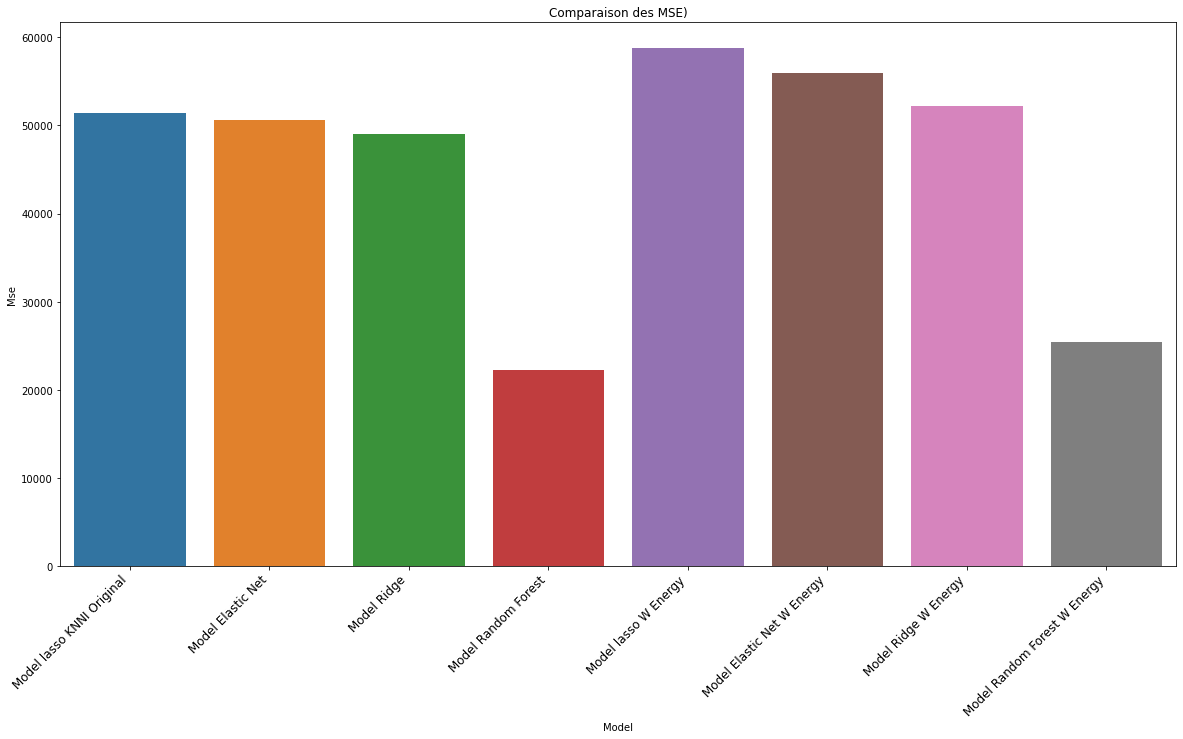

In [125]:
plt.figure(figsize=(20,10))
plt.title('Comparaison des MSE)')
chart = sns.barplot(x = Data_Score['Model'],
           y = Data_Score['Mse'])
chart.set_xticklabels(labels = Data_Score['Model'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
plt.show()

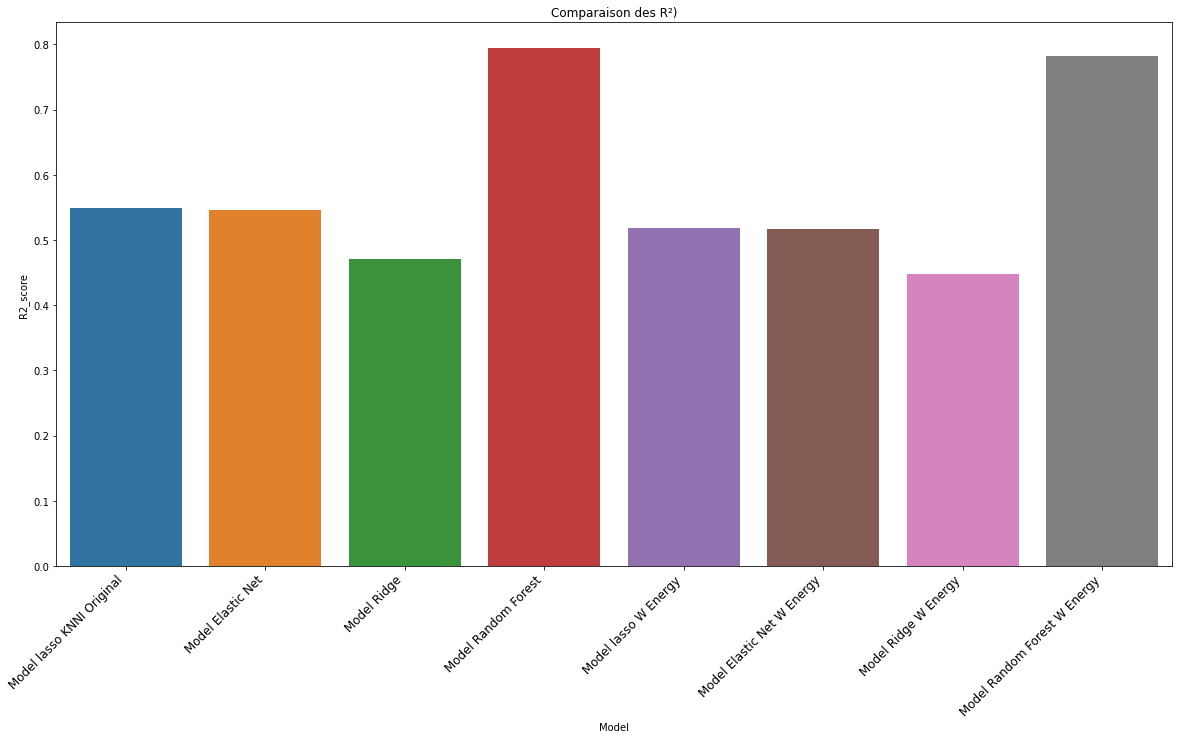

In [126]:
plt.figure(figsize=(20,10))
plt.title('Comparaison des R²)')
chart = sns.barplot(x = Data_Score['Model'],
           y = Data_Score['R2_score'])
chart.set_xticklabels(labels = Data_Score['Model'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
plt.show()

On obtient des scores de métriques R² plus bas  sans la feature "EnergyStar Score" ainsi que des scores d'erreurs plus élevé sans.